In [1]:
%matplotlib inline
import numpy as np
import scipy as sp
import copy
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import pystan

In [3]:
def process_df(df_, offset=0, index_start=-52, index_end=52, cpu=500):
    
    counts_per_user = df_.groupby('UserId').edit_count.agg('sum')
    df_ = df_[df_.UserId.isin(counts_per_user[counts_per_user<cpu].index.unique())]
    
    df_.days = df_.days-offset
    df_['weeks'] = (df_.days).astype(np.int)

    index = np.arange(index_start,index_end)
    week_index = pd.DataFrame({'weeks': index, 'value': np.zeros_like(index)})
    week_count = df_.groupby(['UserId', 'weeks'])[['edit_count']].agg('sum').reset_index()

    df = pd.DataFrame()

    for g, group in week_count.groupby('UserId'):
        merged = pd.merge(week_index, group, how='left', on='weeks')
        merged.UserId.fillna(g, inplace=True)
        df = df.append(merged)

    df.edit_count.fillna(0, inplace=True)
    df.drop(columns=['value'], inplace=True)
    df = df.pivot(index='UserId', columns='weeks')
    return df

df_silver = pd.read_csv('./../data/stack_overflow_edit_count_history-silver1.csv')
df_silver = df_silver.append(pd.read_csv('./../data/stack_overflow_edit_count_history-silver2.csv'))
df_gold = pd.read_csv('./../data/stack_overflow_edit_count_history-gold.csv')
df_false = pd.read_csv('./../data/stack_overflow_edit_count_history-false1.csv')
df_false = df_false.append(pd.read_csv('./../data/stack_overflow_edit_count_history-false2.csv'))

df_false.drop_duplicates(subset=['UserId', 'days'], inplace=True)
df_silver.drop_duplicates(subset=['UserId', 'days'], inplace=True)
df_gold.drop_duplicates(subset=['UserId', 'days'], inplace=True)

df_gold = process_df(df_gold, index_start=-320, index_end=320, cpu=10000)
df_silver = process_df(df_silver, index_start=-320, index_end=320)

print(df_silver.shape, df_gold.shape, df_false.shape)

/home/nick/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(527, 640) (75, 640) (50000, 3)


In [4]:
# plt.figure(figsize=(15,5))
# for trajectory in df_silver.values:
#     plt.plot(np.cumsum(trajectory/np.sum(trajectory)), alpha=.05, c='b')

# for trajectory in df_gold.values:
#     plt.plot(np.cumsum(trajectory/np.sum(trajectory)), alpha=.5, c='g') 
    
# plt.ylim([0,1])

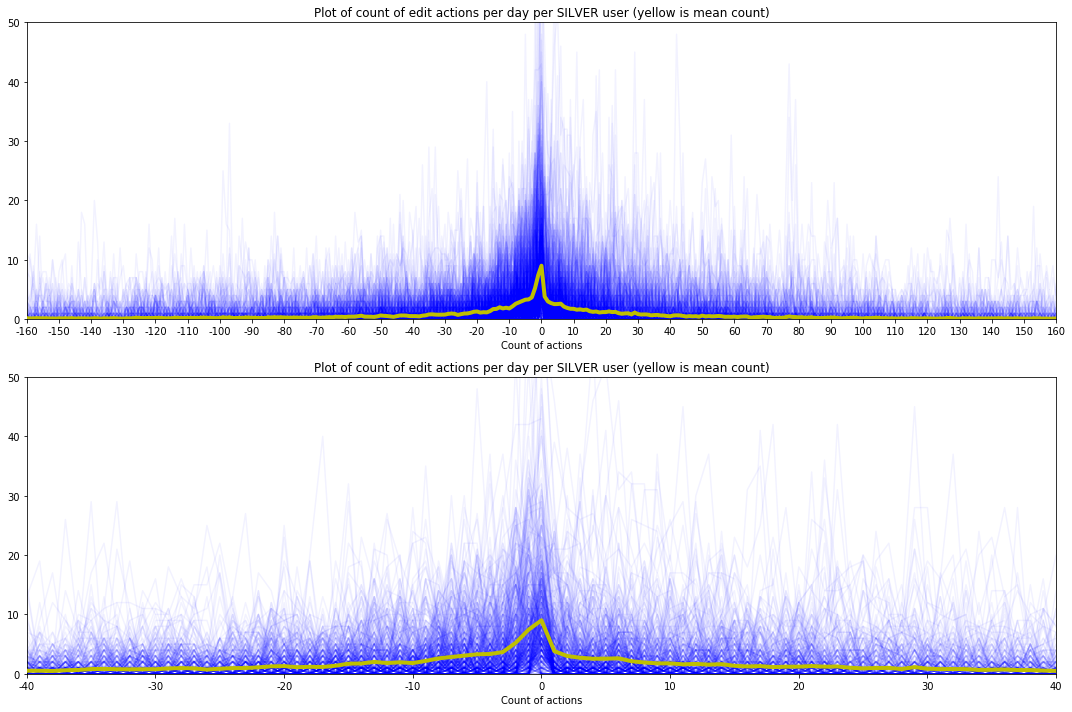

In [5]:
index_start=-320
index_end=320

fig, axes = plt.subplots(2,1,figsize=(15,10))

for trajectory in df_silver.values:
    axes[0].plot(trajectory, alpha=.05, c='b')
    axes[1].plot(trajectory, alpha=.05, c='b')

axes[0].plot(df_silver.mean(axis=0).values, lw=4, alpha=1, c='y', zorder=100)
axes[1].plot(df_silver.mean(axis=0).values, lw=4, alpha=1, c='y', zorder=100)

axes[0].set_xticks(np.arange(0,index_end-index_start,10))
axes[0].set_xticklabels(np.arange(index_start,index_end,10))
axes[1].set_xticks(np.arange(0,index_end-index_start,10))
axes[1].set_xticklabels(np.arange(index_start,index_end,10))

axes[0].set_xlim([index_end/2,2*index_end-index_end/2])
axes[1].set_xlim([index_end-40,index_end+40])

axes[0].set_ylim([0,50])
axes[1].set_ylim([0,50])

for i in range(2):
    
    axes[i].set_title('Plot of count of edit actions per day per SILVER user (yellow is mean count)')
    axes[i].set_xlabel('Days from receiving badge')
    axes[i].set_xlabel('Count of actions')

fig.tight_layout()
plt.show()

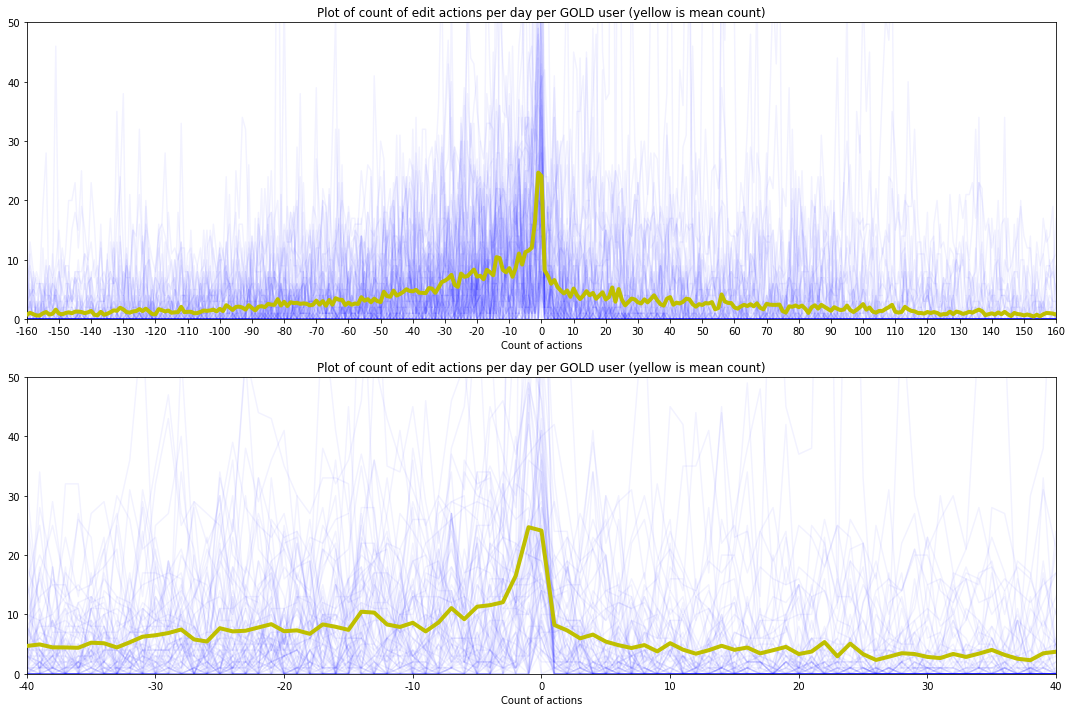

In [6]:
index_start=-320
index_end=320

fig, axes = plt.subplots(2,1,figsize=(15,10))

for trajectory in df_gold.values:
    axes[0].plot(trajectory, alpha=.05, c='b')
    axes[1].plot(trajectory, alpha=.05, c='b')

axes[0].plot(df_gold.mean(axis=0).values, lw=4, alpha=1, c='y', zorder=100)
axes[1].plot(df_gold.mean(axis=0).values, lw=4, alpha=1, c='y', zorder=100)

axes[0].set_xticks(np.arange(0,index_end-index_start,10))
axes[0].set_xticklabels(np.arange(index_start,index_end,10))
axes[1].set_xticks(np.arange(0,index_end-index_start,10))
axes[1].set_xticklabels(np.arange(index_start,index_end,10))

axes[0].set_xlim([index_end/2,2*index_end-index_end/2])
axes[1].set_xlim([index_end-40,index_end+40])

axes[0].set_ylim([0,50])
axes[1].set_ylim([0,50])

for i in range(2):
    
    axes[i].set_title('Plot of count of edit actions per day per GOLD user (yellow is mean count)')
    axes[i].set_xlabel('Days from receiving badge')
    axes[i].set_xlabel('Count of actions')

fig.tight_layout()
plt.show()

<hr />

### Compare to the raw trajectories from the users' first interaction
Let's compare the above trends to the cases where we look at the users' trajectories from the day when they joined. Secondly we look at their trajectories, with the trajectory centered around the day where the user received 20, 50, 100 and 200 badges. 

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


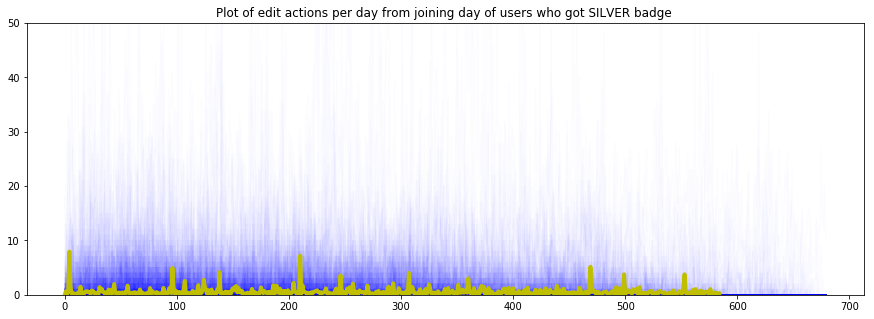

In [7]:
df_false = pd.read_csv('./../data/stack_overflow_edit_count_history-false1.csv')
df_false = df_false.append(pd.read_csv('./../data/stack_overflow_edit_count_history-false2.csv'))
df_false.drop_duplicates(subset=['UserId', 'days'], inplace=True)

fig, ax = plt.subplots(1,1,figsize=(15,5))
max_days = np.max(df_false.days)+1

ts = np.zeros((len(np.unique(df_false.UserId)), max_days))
count = 0
for user, trajectory in df_false.groupby('UserId'):
    
    trajectory.sort_values('days', inplace=True)
    trajectory.set_index('days', inplace=True)
    t = np.zeros(max_days)
    
    for i,v in trajectory.edit_count.iteritems():
        t[i] = v
    ts[count] = t
    count += 1
    ax.plot(t, alpha=.01, c='b')
    
ax.plot(np.mean(ts, axis=1), lw=4, alpha=1, c='y', zorder=100)
ax.set_ylim([0,50])
ax.set_title('Plot of edit actions per day from joining day of users who got SILVER badge ')
plt.show()

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


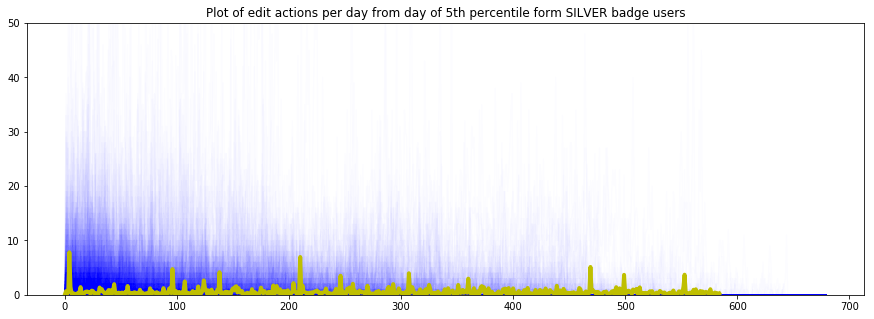

In [8]:
df_false = pd.read_csv('./../data/stack_overflow_edit_count_history-false1.csv')
df_false = df_false.append(pd.read_csv('./../data/stack_overflow_edit_count_history-false2.csv'))
df_false.drop_duplicates(subset=['UserId', 'days'], inplace=True)

fig, ax = plt.subplots(1,1,figsize=(15,5))
max_days = np.max(df_false.days)+1

ts = np.zeros((len(np.unique(df_false.UserId)), max_days))
count = 0
for user, trajectory in df_false.groupby('UserId'):
        
    min_ = int(np.percentile(trajectory.days, 5))
    trajectory.sort_values('days', inplace=True)
    trajectory.set_index('days', inplace=True)
    t = np.zeros(max_days)

    for i,v in trajectory.edit_count.iteritems():
        if i-min_ > 0:
            t[i-min_] = v
    ts[count] = t
    count += 1
    ax.plot(t, alpha=.01, c='b')
    
ax.plot(np.mean(ts, axis=1), lw=4, alpha=1, c='y', zorder=100)
ax.set_ylim([0,50])
ax.set_title('Plot of edit actions per day from day of 5th percentile form SILVER badge users')
plt.show()

In [9]:
np.percentile(df_false.days, 90)

475.0

There doesn't seem to be a clear pattern. Now if we rather center the trajectories around the the day when the users' achiever X edits (where X $\in$ 20, 50, 100 and 200) we see a different story:

/home/nick/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)
/home/nick/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/p

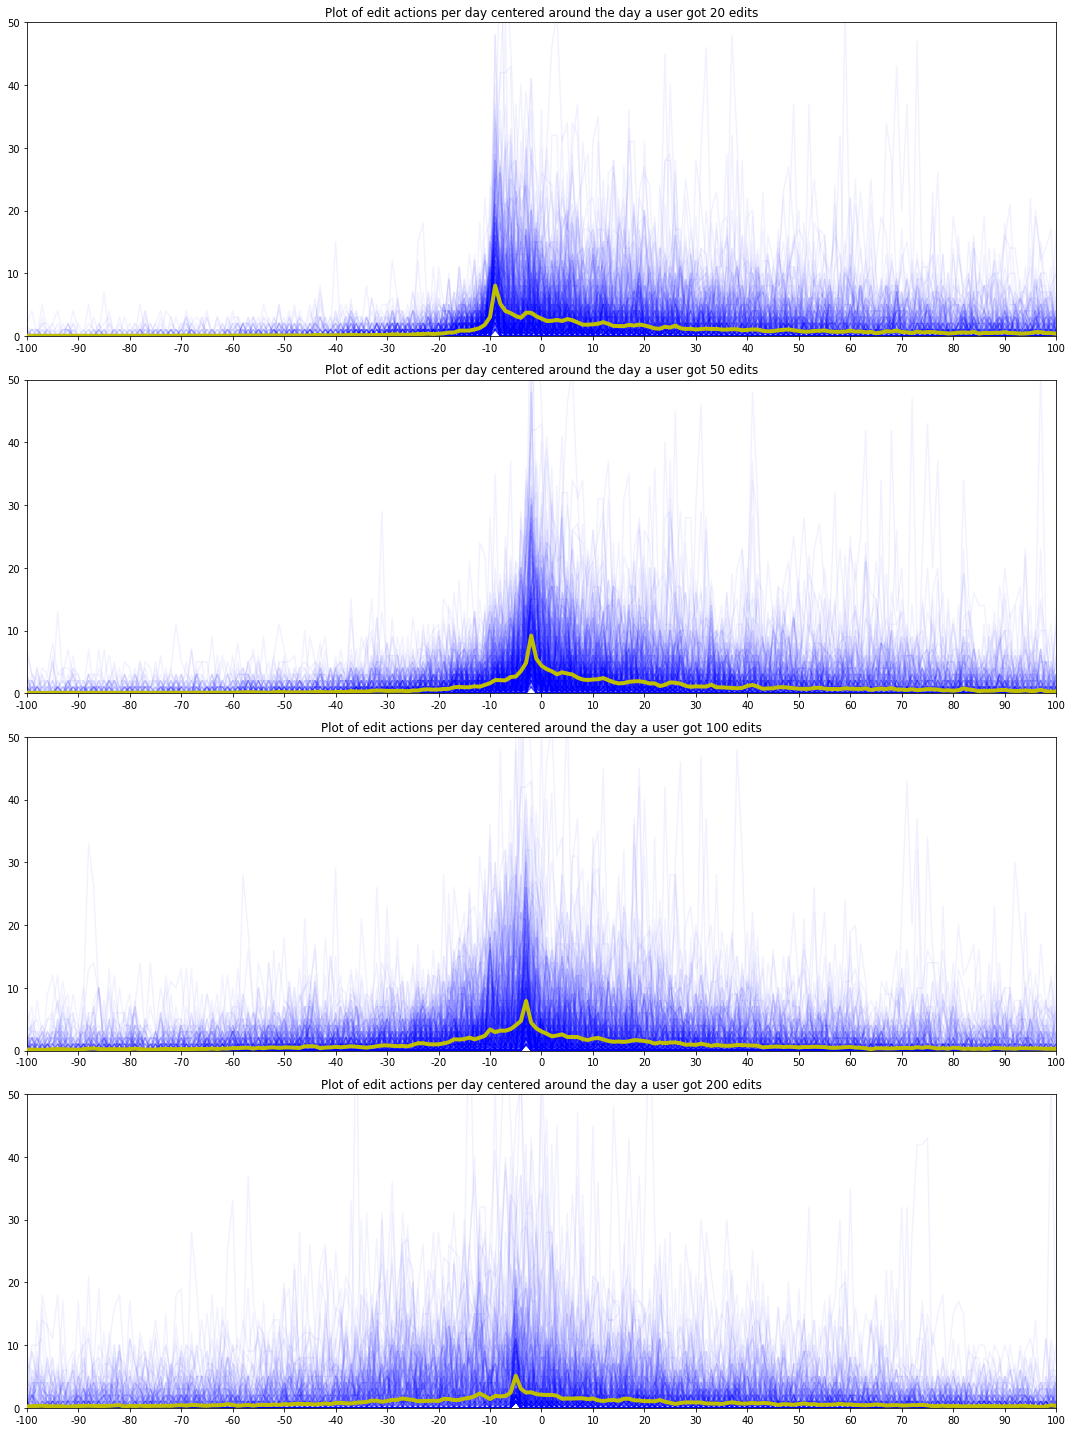

In [10]:
fig, axes = plt.subplots(4,1,figsize=(15,20))

df_false = pd.read_csv('./../data/stack_overflow_edit_count_history-false1.csv')
df_false = df_false.append(pd.read_csv('./../data/stack_overflow_edit_count_history-false2.csv'))
df_false.drop_duplicates(subset=['UserId', 'days'], inplace=True)

for k,target in enumerate([20,50,100,200]):
    df_false_ = df_false.copy()
    
    df = df_false.sort_values(['UserId', 'days']).set_index(['UserId', 'days']).cumsum()
    d = df - df.reset_index().groupby(['UserId']).agg(min)[['edit_count']]

    user_to_count = {}
    for i, row in (d > target).groupby('UserId').agg(np.argmax).reset_index().iterrows():
        user_to_count[row.edit_count[0]] = row.edit_count[1]
    
    df_false_.days = df_false_.apply(lambda x: x['days'] - user_to_count[x['UserId']], axis=1)
    
    min_days = df_false_.days.min()
    max_days = df_false_.days.max()
    df_false_ = process_df(df_false_, index_start=min_days, index_end=max_days)
    
    for trajectory in df_false_.values:
        axes[k].plot(trajectory, alpha=.05, c='b')
    
    correction1 = max_days%10
    correction2 = min_days%10
    axes[k].plot(df_false_.mean(axis=0).values, lw=4, alpha=1, c='y', zorder=100)
    
    ticks = np.arange(0,(max_days-correction1)-(min_days-correction2),10)
    labels = np.arange(min_days-correction2,max_days-correction1,10)

    axes[k].set_xticks(ticks)
    axes[k].set_xticklabels(labels)
    
    day0 = labels.tolist().index(0)
    axes[k].set_xlim([ticks[day0]-100,ticks[day0]+100])
    axes[k].set_ylim([0,50])
    axes[k].set_title(f'Plot of edit actions per day centered around the day a user got {target} edits')
    
fig.tight_layout()
plt.show()

/home/nick/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:4401: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


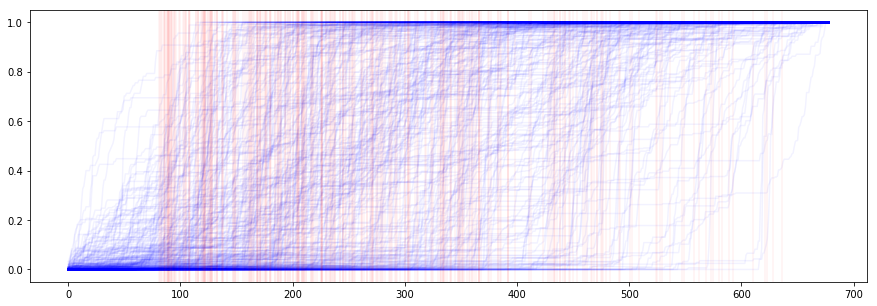

In [11]:
df_false = pd.read_csv('./../data/stack_overflow_edit_count_history-false1.csv')
df_false = df_false.append(pd.read_csv('./../data/stack_overflow_edit_count_history-false2.csv'))
df_false.drop_duplicates(subset=['UserId', 'days'], inplace=True)

index_start = df_false.days.min()
index_end = df_false.days.max()
df_false = process_df(df_false, index_start=index_start, index_end=index_end)

plt.figure(figsize=(15,5))
for trajectory in df_false.values:

    cs = np.cumsum(trajectory)
    
    got_to_80 = np.argmax(cs > 80)
    if got_to_80 > 80:
        plt.plot(cs/np.sum(trajectory), alpha=.05, c='b')
        plt.axvline(got_to_80, alpha=.05, c='r')

# plt.plot(df_false.mean(axis=0).values, lw=4, alpha=1, c='y', zorder=100)
# plt.xticks(np.arange(0,104), np.arange(-52,52))
# plt.xlim([30,74])
# plt.ylim([0,30])
plt.show()

Some useful statistics that will help to reproduce these results

In [12]:
df_false = pd.read_csv('./../data/stack_overflow_edit_count_history-false1.csv')
df_false = df_false.append(pd.read_csv('./../data/stack_overflow_edit_count_history-false2.csv'))
df_false.drop_duplicates(subset=['UserId', 'days'], inplace=True)

cpu = 500
counts_per_user = df_false.groupby('UserId').edit_count.agg('sum')
df_false = df_false[df_false.UserId.isin(counts_per_user[counts_per_user<cpu].index.unique())]
print("Median days to start interacting:", np.median(df_false.groupby('UserId').agg('min').days))

Median days to start interacting: 20.0


In [13]:
d = df_false.groupby('UserId').agg(['min', 'max']).days
print("Median number of days between first and last interaction", np.median(d['max'] - d['min']))

Median number of days between first and last interaction 285.5


Median number of days between 95% and 5% interaction 143.60000000000002


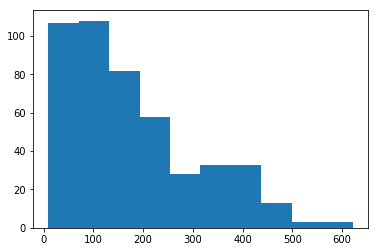

In [14]:
def percentile(n):
    def percentile_(x):
        return np.percentile(x, n)
    percentile_.__name__ = 'percentile_%s' % n
    return percentile_

d = df_false.groupby('UserId').agg([percentile(10), percentile(90)]).days
print("Median number of days between 95% and 5% interaction", np.median(d['percentile_90'] - d['percentile_10']))
plt.hist(d['percentile_90'] - d['percentile_10'])
plt.show()

In [15]:
index_start = df_false.days.min()
index_end = df_false.days.max()
df_false = process_df(df_false, index_start=index_start, index_end=index_end)
trajectories = df_false.values
np.mean(np.sum(trajectories, axis=1)), np.var(np.sum(trajectories, axis=1))

(221.19871794871796, 12888.295981262327)

# Simulations 
Checking to see if this is purely statistical noise. Assumptions:

    1) A user has a base rate for interacting with the system

    2) A user interacts for some subset of time between 10 and 500 days
    
    3) When a user interacts, it is a poisson count of interactions on that day following the user's base rate

In [2]:
def covariance(time, badge, length=80**2):
#     return np.exp(-((time-badge)**2)/length) + .25
    return 1/720

In [43]:
def generate_users_trajectory(t_length, expected_rate, probability=.2):
    
    trajectory = np.zeros(t_length)
    
    starting_delay = 500
    while starting_delay >= 500:
        starting_delay = int(np.random.gamma(2,150))
    
    options = np.arange(10, 720-starting_delay)
    probs = (options[::-1] ** 3)
    probs = probs/np.sum(probs)
    
    length_of_interaction = np.random.choice(options, p=probs)

    prob = probability
    for i in range(length_of_interaction):
        if np.random.binomial(1, probability):
            trajectory[starting_delay + i] = np.random.poisson(np.random.gamma(expected_rate*10, 150/length_of_interaction))
            prob *= .99
    return trajectory

In [88]:
trajectories = np.array([generate_users_trajectory(720, np.random.gamma(1,2), np.random.beta(10,2)) for i in range(5000)])

In [89]:
print(trajectories.shape)
trajectories = trajectories[np.sum(trajectories, axis=1) >= 80]
print(trajectories.shape)
trajectories = trajectories[np.sum(trajectories, axis=1) < 500]
print(trajectories.shape)
# trajectories = trajectories[:500]

(5000, 720)
(4835, 720)
(779, 720)


In [90]:
np.sum(np.sum(trajectories, axis=1) >= 80)

779

In [94]:
for i in np.random.choice(np.arange(trajectories.shape[0]), size=100, replace=False):
    traj = trajectories[i]
    cum_sum_traj = np.cumsum(traj)
    got_to_80 = np.argmax(cum_sum_traj >= 80)
    trajectories[i][got_to_80+1:] = 0

777 477
371 146
265 184
90 166
313 199
65 476
431 261
542 66
176 173
308 489
361 178
573 317
321 261
534 181
337 370
517 412
589 98
645 165
549 118
532 301
551 156
23 120
7 154
637 207
360 211
270 368
89 224
353 107
707 256
198 137
414 210
759 203
13 322
393 366
763 226
299 368
214 498
171 191
197 492
657 297
577 450
306 578
312 398
230 251
17 415
453 381
249 210
22 335
357 193
48 313
346 205
606 166
397 413
655 228
38 282
565 248
457 94
301 262
591 177
61 442
74 49
384 252
356 345
210 98
536 176
540 437
708 492
505 365
652 224
330 181
394 473
562 79
537 396
554 281
720 93
99 123
347 433
178 122
208 143
395 215
29 398
115 146
674 228
599 320
632 162
429 172
159 264
656 463
36 323
423 361
641 216
469 202
222 419
529 483
231 484
253 120
341 266
284 270
706 81
604 272


In [95]:
np.sum(np.sum(trajectories, axis=1) >= 80)

779

In [96]:
# # generate some target numbers
# # 275 = alpha*beta
# # 14602 = alpha*beta**2
# # beta = 14602/275 = 50
# # alpha = 275**2/14602 = 5.2
# users = [np.random.gamma(2.5,100) for i in range(5000)]
# trajectories = np.array([np.random.poisson(np.random.gamma(.05*u/np.sqrt(100), 500/u, size=720)) for u in users])

# probs = np.random.gamma(np.arange(719,-1,-1)/719,(np.arange(719,-1,-1)/719)**2)
# set_to_zero1 = np.random.choice(np.arange(0,720), p=np.arange(0,720)/np.sum(np.arange(0,720)), size=len(trajectories))
# set_to_zero2 = np.random.choice(np.arange(0,720), p=probs/np.sum(probs), size=len(trajectories))

# # for i in range(len(trajectories)):
# #     trajectories[i] = np.roll(trajectories[i], set_to_zero2[i])
    
# for i in range(len(trajectories)):
#     trajectories[i,set_to_zero1[i]:] = 0
#     trajectories[i,:set_to_zero2[i]] = 0

# trajectories = trajectories[np.sum(trajectories, axis=1) > 80]
# trajectories = trajectories[np.sum(trajectories, axis=1) < 500]
# print(len(trajectories))
# indexes = np.random.choice(np.arange(0, len(trajectories)), replace=False, size=500)
# trajectories = trajectories[indexes]
# trajectories.shape

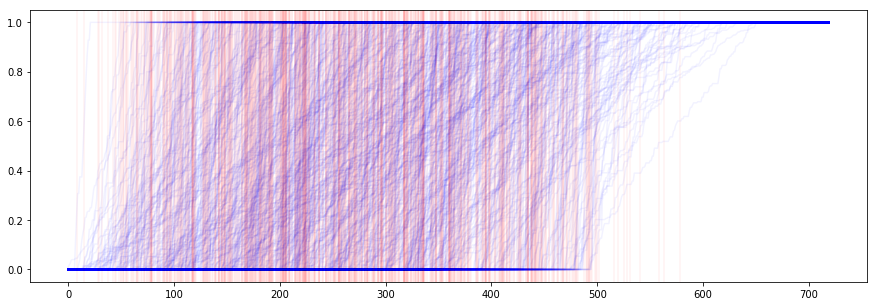

In [97]:
plt.figure(figsize=(15,5))
for trajectory in trajectories:
    cs = np.cumsum(trajectory)
    got_to_80 = np.argmax(cs >= 75)
    if got_to_80 == 0:
        print(np.sum(trajectory))
    plt.plot(cs/np.sum(trajectory), alpha=.05, c='b')
    plt.axvline(got_to_80, alpha=.05, c='r')

# plt.plot(np.mean(shifted_t, axis=0), lw=4, alpha=1, c='y', zorder=100)

# plt.xticks(np.arange(0,len(shifted_t)), np.arange(-np.max(id_to_get_badge),100))
# plt.xlim([np.max(id_to_get_badge)-20,np.max(id_to_get_badge)+20])
plt.show()

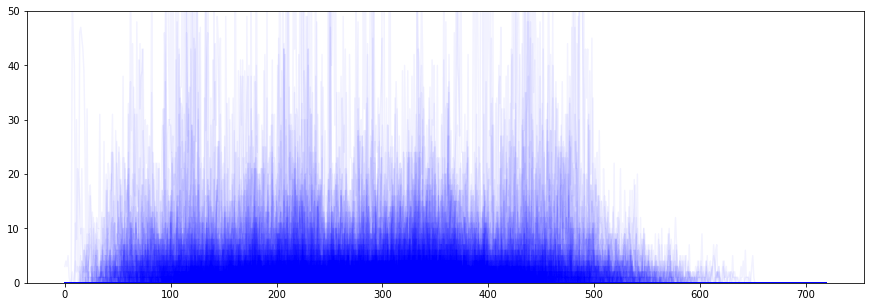

In [98]:
plt.figure(figsize=(15,5))
for trajectory in trajectories:
    plt.plot(trajectory, alpha=.05, c='b')

# plt.plot(np.mean(shifted_t, axis=0), lw=4, alpha=1, c='y', zorder=100)

# plt.xticks(np.arange(0,len(shifted_t)), np.arange(-np.max(id_to_get_badge),100))
# plt.xlim([np.max(id_to_get_badge)-20,np.max(id_to_get_badge)+20])
plt.ylim([0,50])
plt.show()

In [99]:
d = trajectories.cumsum(axis=1)
badge = 80
id_to_get_badge = np.argmax(d >= badge, axis=1)

In [100]:
shifted_t = np.concatenate([np.zeros((len(trajectories), np.max(id_to_get_badge))), trajectories], axis=1)
shifted_t.shape

(779, 1298)

In [101]:
for i, id_ in enumerate(id_to_get_badge):
    shifted_t[i] = np.roll(shifted_t[i], -id_)

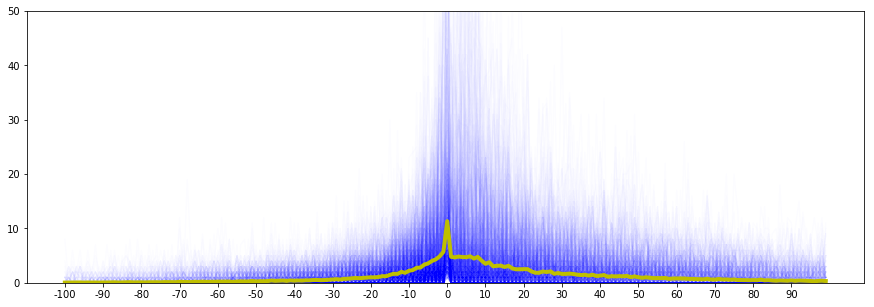

In [102]:
plt.figure(figsize=(15,5))
for trajectory in shifted_t:
    if np.sum(trajectory) >= badge:
        plt.plot(trajectory[np.max(id_to_get_badge)-100:np.max(id_to_get_badge)+100], alpha=.01, c='b')

# plt.plot(np.mean(shifted_t, axis=0), lw=4, alpha=1, c='y', zorder=100)
plt.plot(np.mean(shifted_t[:,np.max(id_to_get_badge)-100:np.max(id_to_get_badge)+100], axis=0), c='y', lw=4)
plt.xticks(np.arange(0,200,10), np.arange(-100,100,10))
# plt.xlim([np.max(id_to_get_badge)-150,np.max(id_to_get_badge)+300])
plt.ylim([0,50])
plt.show()

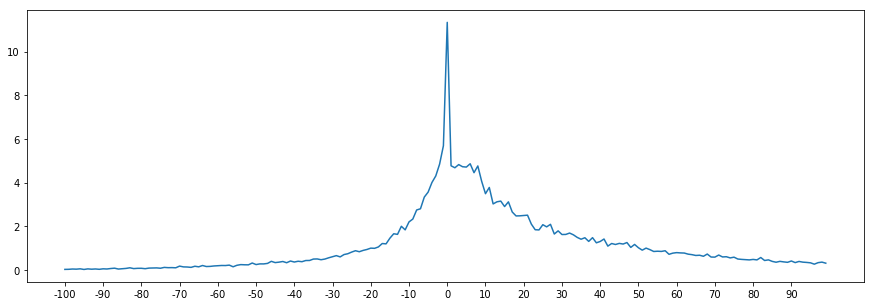

In [103]:
plt.figure(figsize=(15,5))

plt.plot(np.mean(shifted_t[:,np.max(id_to_get_badge)-100:np.max(id_to_get_badge)+100], axis=0))

plt.xticks(np.arange(0,200,10), np.arange(-100,100,10))
# plt.xticks(np.arange(0,len(shifted_t)), np.arange(-np.max(id_to_get_badge),100))
# plt.xlim([np.max(id_to_get_badge)-20,np.max(id_to_get_badge)+20])
plt.show()

(array([51., 51., 48., 62., 55., 49., 47., 44., 48., 45.]),
 array([ 83. , 124.6, 166.2, 207.8, 249.4, 291. , 332.6, 374.2, 415.8,
        457.4, 499. ]),
 <a list of 10 Patch objects>)

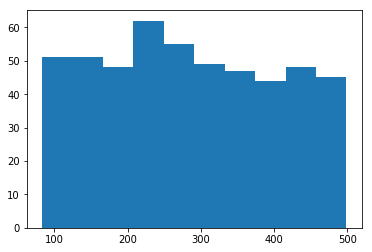

In [28]:
plt.hist(np.sum(trajectories, axis=1))

(array([ 77., 121.,  72.,  66.,  56.,  35.,  28.,  23.,  22.,  27.]),
 array([ 69., 112., 155., 198., 241., 284., 327., 370., 413., 456., 499.]),
 <a list of 10 Patch objects>)

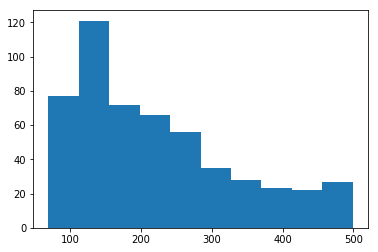

In [29]:
df_silver = pd.read_csv('./../data/stack_overflow_edit_count_history-silver1.csv')
df_silver = df_silver.append(pd.read_csv('./../data/stack_overflow_edit_count_history-silver2.csv'))
cpu = 500
counts_per_user = df_silver.groupby('UserId').edit_count.agg('sum')
df_silver = df_silver[df_silver.UserId.isin(counts_per_user[counts_per_user<cpu].index.unique())]

plt.hist(df_silver.groupby('UserId').edit_count.agg('sum'))

(array([53., 48., 80., 71., 64., 49., 62., 51., 26., 23.]),
 array([ 13. ,  84.2, 155.4, 226.6, 297.8, 369. , 440.2, 511.4, 582.6,
        653.8, 725. ]),
 <a list of 10 Patch objects>)

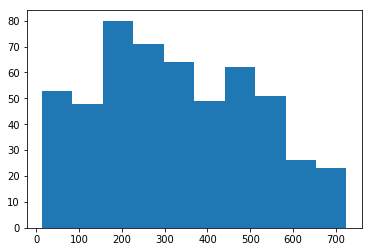

In [30]:
d = df_silver.groupby('UserId').agg(['min', 'max']).days
plt.hist(d['max'] - d['min'])

(array([171., 123.,  63.,  50.,  49.,  19.,   7.,  10.,   5.,   3.]),
 array([  6. ,  48.7,  91.4, 134.1, 176.8, 219.5, 262.2, 304.9, 347.6,
        390.3, 433. ]),
 <a list of 10 Patch objects>)

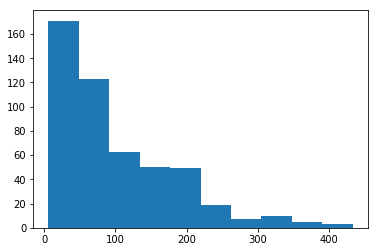

In [31]:
min_ = np.argmax(trajectories > 0, axis=1)
max_ = 720-np.argmax(trajectories[:,::-1] > 0, axis=1)
plt.hist(max_-min_)

(array([325.,  98.,  51.,  15.,   5.,   2.,   2.,   1.,   0.,   1.]),
 array([  3. ,  22.4,  41.8,  61.2,  80.6, 100. , 119.4, 138.8, 158.2,
        177.6, 197. ]),
 <a list of 10 Patch objects>)

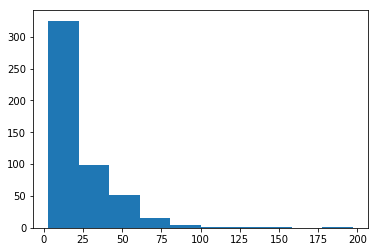

In [32]:
plt.hist(np.max(trajectories, axis=1))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5e64987e80>]],
      dtype=object)

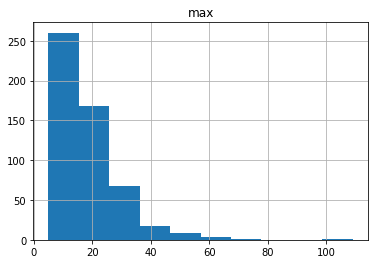

In [33]:
df_silver.groupby('UserId').edit_count.agg(['max']).hist()

What if we make an extreme case to study

In [34]:
def generate_users_trajectory(t_length, expected_rate, probability=.25):
    
    trajectory = np.zeros(t_length)
    
    starting_delay = 500
    while starting_delay >= 500:
        starting_delay = int(np.random.gamma(2,100))
    
    options = np.arange(10, 720-starting_delay)
    probs = (options[::-1] ** 3)
    probs = probs/np.sum(probs)
    
    length_of_interaction = np.random.negative_binomial(n=10, p=.25)

    prob = probability
    for i in range(length_of_interaction):
        if np.random.binomial(1, probability):
            trajectory[starting_delay + i] = np.random.poisson(np.random.gamma(expected_rate*10, 150/length_of_interaction))
    return trajectory


In [35]:
trajectories = np.array([generate_users_trajectory(720, np.random.gamma(.1,10), np.random.beta(10,2)) for i in range(5000)])

In [36]:
print(trajectories.shape)
trajectories = trajectories[np.sum(trajectories, axis=1) > 80]
print(trajectories.shape)
trajectories = trajectories[np.sum(trajectories, axis=1) < 500]
print(trajectories.shape)
trajectories = trajectories[:500]

(5000, 720)
(1821, 720)
(630, 720)


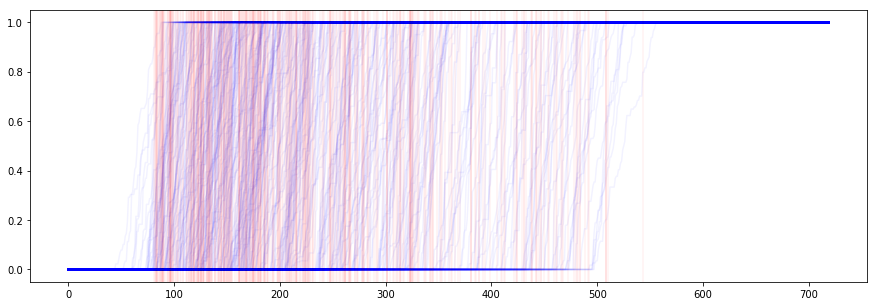

In [37]:
plt.figure(figsize=(15,5))
for trajectory in trajectories:
    cs = np.cumsum(trajectory)
    got_to_80 = np.argmax(cs > 80)
    if got_to_80 > 80:
        plt.plot(cs/np.sum(trajectory), alpha=.05, c='b')
        plt.axvline(got_to_80, alpha=.05, c='r')

# plt.plot(np.mean(shifted_t, axis=0), lw=4, alpha=1, c='y', zorder=100)

# plt.xticks(np.arange(0,len(shifted_t)), np.arange(-np.max(id_to_get_badge),100))
# plt.xlim([np.max(id_to_get_badge)-20,np.max(id_to_get_badge)+20])
plt.show()

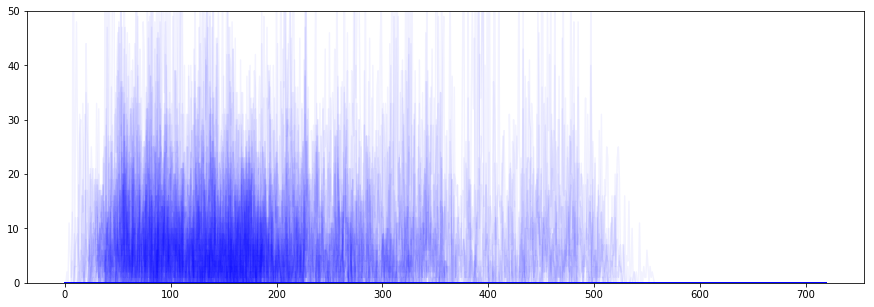

In [38]:
plt.figure(figsize=(15,5))
for trajectory in trajectories:
    plt.plot(trajectory, alpha=.05, c='b')

# plt.plot(np.mean(shifted_t, axis=0), lw=4, alpha=1, c='y', zorder=100)

# plt.xticks(np.arange(0,len(shifted_t)), np.arange(-np.max(id_to_get_badge),100))
# plt.xlim([np.max(id_to_get_badge)-20,np.max(id_to_get_badge)+20])
plt.ylim([0,50])
plt.show()

In [39]:
d = trajectories.cumsum(axis=1)
badge = 80
id_to_get_badge = np.argmax(d >= badge, axis=1)

In [40]:
shifted_t = np.concatenate([np.zeros((len(trajectories), np.max(id_to_get_badge))), trajectories], axis=1)
shifted_t.shape

(500, 1260)

In [41]:
for i, id_ in enumerate(id_to_get_badge):
    shifted_t[i] = np.roll(shifted_t[i], -id_)

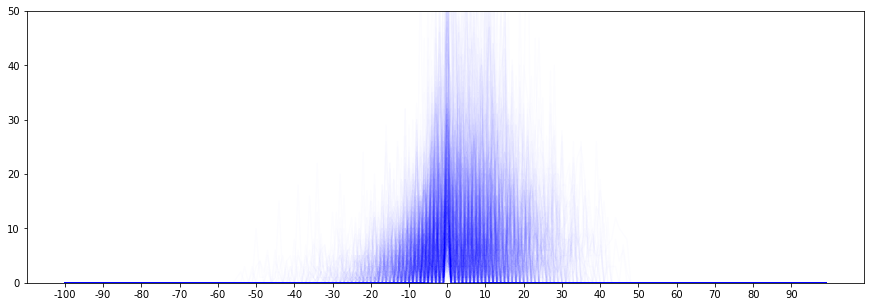

In [42]:
plt.figure(figsize=(15,5))
for trajectory in shifted_t:
    if np.sum(trajectory) >= badge:
        plt.plot(trajectory[np.max(id_to_get_badge)-100:np.max(id_to_get_badge)+100], alpha=.01, c='b')

# plt.plot(np.mean(shifted_t, axis=0), lw=4, alpha=1, c='y', zorder=100)

# plt.xticks(np.arange(0,len(shifted_t.T)), np.arange(-np.max(id_to_get_badge),720))
# plt.xlim([np.max(id_to_get_badge)-150,np.max(id_to_get_badge)+300])
plt.xticks(np.arange(0,200,10), np.arange(-100,100,10))
plt.ylim([0,50])
plt.show()

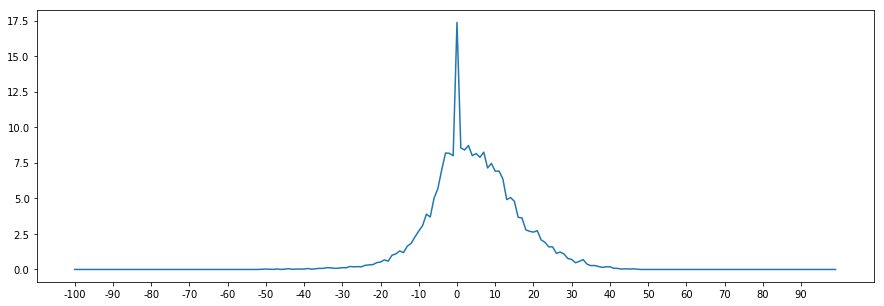

In [43]:
plt.figure(figsize=(15,5))

plt.plot(np.mean(shifted_t[:,np.max(id_to_get_badge)-100:np.max(id_to_get_badge)+100], axis=0))

# plt.xticks(np.arange(0,len(shifted_t)), np.arange(-np.max(id_to_get_badge),100))
# plt.xlim([np.max(id_to_get_badge)-20,np.max(id_to_get_badge)+20])
plt.xticks(np.arange(0,200,10), np.arange(-100,100,10))
plt.show()

Considering the rate of user's interactions:

In [363]:
df_false = pd.read_csv('./../data/stack_overflow_edit_count_history-false1.csv')
df_false = df_false.append(pd.read_csv('./../data/stack_overflow_edit_count_history-false2.csv'))
df_false.drop_duplicates(subset=['UserId', 'days'], inplace=True)
# df_false.days = df_false.days//7

In [45]:
# get the length of time in days to:
    # get from 50 posts to 60
    # get from 60 posts to 70
    # get from 70 posts to 80
    # get from 80 posts to 90
    
def get_num_days_between_edit_counts(user, lower, upper):

    counts = user.sort_values('edit_count').set_index('days').cumsum()
    num_days = counts[(counts.edit_count > lower) & (counts.edit_count <= upper)].reset_index()
    min_days = num_days.days.min()
    max_days = num_days.days.max()
    num_from_lower_to_upper = max_days - min_days
    
    if np.isnan(num_from_lower_to_upper):
        return -1
    return num_from_lower_to_upper

In [46]:
np.random.choice(df_false.UserId.unique(), replace=False, size=5)

array([8306666, 7167572, 6926168, 7368985, 9219620])

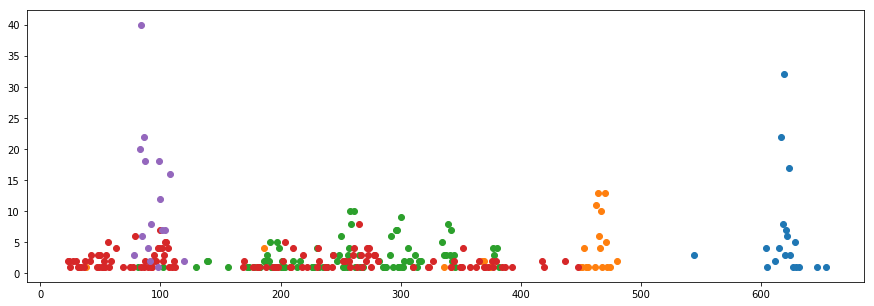

In [47]:
np.random.seed(11)
fig, ax = plt.subplots(1,1, figsize=(15,5))
for user_id in np.random.choice(df_false.UserId.unique(), replace=False, size=5):
    user = df_false[df_false.UserId == user_id]
    x = user.sort_values('days').days
    y = user.sort_values('days').edit_count
    ax.scatter(x,y)

In [2211]:
counts = {}
count_range = [(30,40),(40,50),(50,60),(60,70),(70,80),
               (80,90),(90,100),(100,110),(110,120),(120,130),
               (130,140),(140,150),(140,150),(150,160),(160,170),
               (170,180), (180,190), (190,200)]
count_range = [(30,50),(50,70),(70,90),(90,110),(110,130),
               (130,150),(150,170),(170,190),(190,210),(210,230)]
count_range = [(i-10,j-10) for i,j in count_range]
for g,user in df_false.groupby('UserId'):
    for i, (lw, up) in enumerate(count_range[:-1]):
        if f'{lw}-{up}' not in counts:
            counts[f'{lw}-{up}'] = []
        lower_count = get_num_days_between_edit_counts(user, lw, up)
        upper_count = get_num_days_between_edit_counts(user, count_range[i+1][0], count_range[i+1][1])
        if upper_count > 0 and lower_count > 0:
            counts[f'{lw}-{up}'].append(upper_count-lower_count)

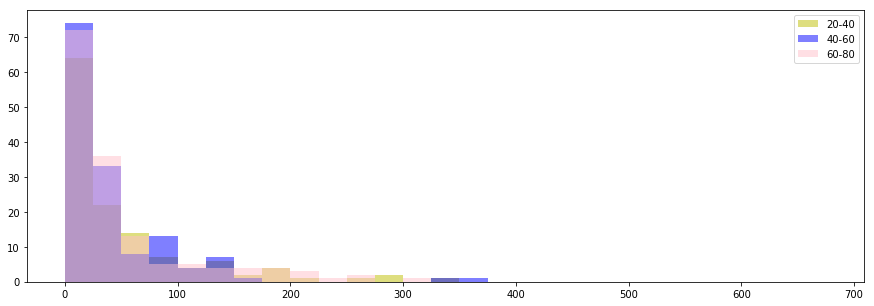

In [2212]:
c = ['y', 'b', 'pink']
fig, ax = plt.subplots(1,1,figsize=(15,5))
for i,chart in enumerate([f'{lw}-{up}' for (lw, up) in count_range][0:3]):
    ax.hist(counts[chart], bins=np.arange(0,700,25), alpha=.5, label = chart, color=c[i])
ax.legend(loc='best')

In [2213]:
import seaborn as sns

Text(0.5,0,'Number of edits {lower} - {upper}')

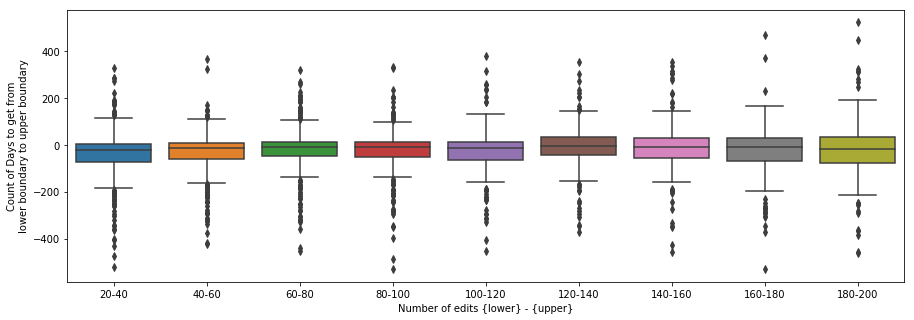

In [2215]:
fig, ax = plt.subplots(1,1, figsize=(15,5))
df = pd.DataFrame()
adjusted_counts = []

for l,d in counts.items():

    df_ = pd.DataFrame({l:d})
    adjusted_counts.append(d)
    df_['name'] = l
    df_= df_.set_index('name').rename(columns={l: 'day_counts'})
    df = df.append(df_)

df = df.reset_index()
sns.boxplot(x=df.name, y=df.day_counts)
ax.set_ylabel('Count of Days to get from\nlower boundary to upper boundary')
ax.set_xlabel('Number of edits {lower} - {upper}')
# ax.set_ylim([-100, 100])

In [ ]:
# import scipy.stats as stats
# stats.kruskal(*adjusted_counts[:3])

In [ ]:
keys = list(counts.keys())
fig, axes = plt.subplots(4,2,figsize=(15,20))
axes = axes.flatten()

for i in range(8):
    
    print(f'Comparing {keys[i+1]} to ({keys[i]} and {keys[i+2]})')
    samp_base = adjusted_counts[i] + adjusted_counts[i+2] 
    samp_test = adjusted_counts[i+1]
    
    axes[i].hist(samp_base, normed=True, label='Baseline', alpha=.5)
    axes[i].hist(samp_test, normed=True, label='Observed Group', alpha=.5)
    axes[i].legend(loc='best')
    axes[i].set_title(f'Comparing Observed: {keys[i+1]}\nto Baseline: ({keys[i]} and {keys[i+2]})')
    
    k_res = stats.kruskal(samp_test, samp_base)
    # downsample the larger group to meet the smaller group
    if len(samp_base) > len(samp_test):
        samp_base = np.random.choice(samp_base, replace=False, size=len(samp_test))
    elif len(samp_base) > len(samp_test):
        samp_test = np.random.choice(samp_test, replace=False, size=len(samp_base))
    
    hist_base = np.histogram(samp_base, bins=np.arange(0,700,50))[0] + 1
    hist_test = np.histogram(samp_test, bins=np.arange(0,700,50))[0] + 1
    
    print('Expected counts:', hist_base)
    print('Observed counts:', hist_test)
    
    print(k_res)
    print('----------------------------------------------------')
    print()

In [ ]:
to_test = counts['70-90']
to_compare = []
for k,v in counts.items():
    if k in ['50-70', '90-110']:
        to_compare += v
        

In [ ]:
hist_base = np.histogram(to_compare, bins=np.arange(0,700,50))[0]
hist_test = np.histogram(to_test, bins=np.arange(0,700,50))[0]
print((hist_base/np.sum(hist_base)*np.sum(hist_test)))
print(hist_test)

In [ ]:
plt.hist(to_compare, normed=True, bins=np.arange(0,700,50), alpha=.5)
plt.hist(to_test, normed=True, bins=np.arange(0,700,50), alpha=.5)

In [ ]:
stats.kruskal(to_test, to_compare)

In [ ]:
fig, ax = plt.subplots(1,1,figsize=(15,15))

user_index = 0
max_days = df_false.days.max()+1

for g, group in df_false.groupby('UserId'):

    x_axis = group.days
    y_axis = np.ones_like(x_axis) * user_index
    
    ax.scatter(x_axis, y_axis, c='b', alpha=.1)
    user_index += 1

In [ ]:
df_silver = pd.read_csv('./../data/stack_overflow_edit_count_history-silver1.csv')
df_silver = df_silver.append(pd.read_csv('./../data/stack_overflow_edit_count_history-silver2.csv'))
df_silver.drop_duplicates(subset=['UserId', 'days'], inplace=True)

df_silver.drop_duplicates(subset=['UserId', 'days'], inplace=True)
counts_per_user = df_silver.groupby('UserId').edit_count.agg('sum')
df_silver = df_silver[df_silver.UserId.isin(counts_per_user[counts_per_user<500].index.unique())]

fig, ax = plt.subplots(1,1,figsize=(15,15))

user_index = 0
max_days = df_false.days.max()+1

for g, group in df_silver.groupby('UserId'):

    x_axis = group.days
    y_axis = np.ones_like(x_axis) * user_index
    
    ax.scatter(x_axis, y_axis, c='b', alpha=.1)
    user_index += 1
    
ax.set_ylabel('Unique UserID')
ax.set_xlabel('Day relative to Day 0 where user got Silver Badge')

/home/nick/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmax' is deprecated, use 'idxmax' instead. The behavior of 'argmax'
will be corrected to return the positional maximum in the future.
Use 'series.values.argmax' to get the position of the maximum now.
  return getattr(obj, method)(*args, **kwds)


Text(0.5,0,'Day relative to Day 0 where user got Silver Badge')

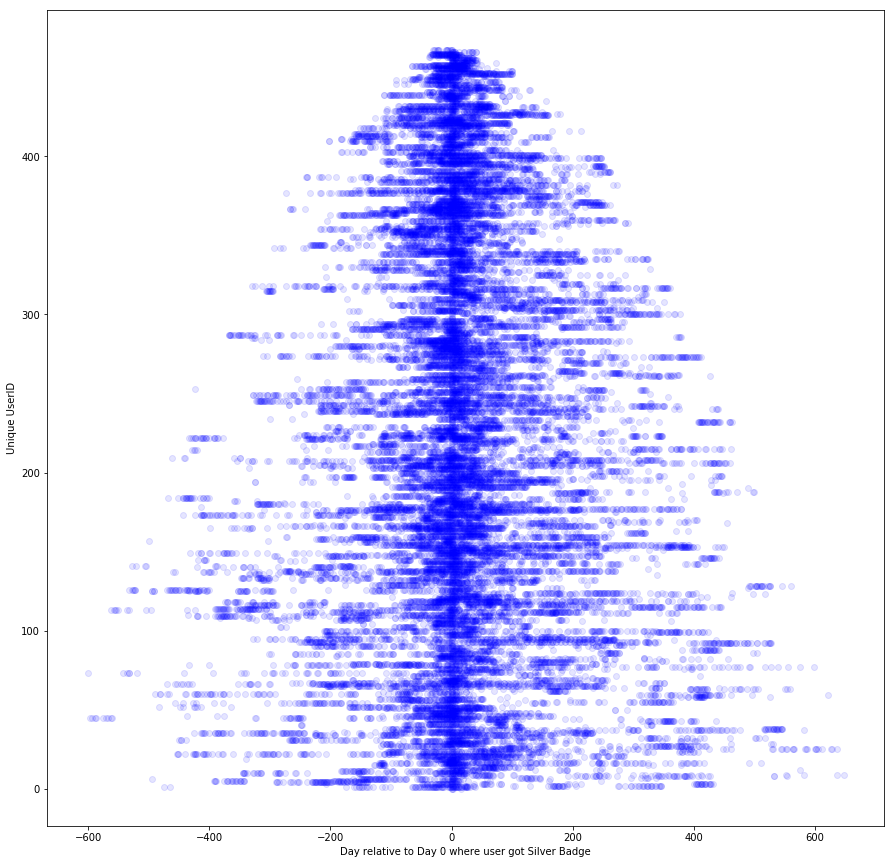

In [364]:
df_false_ = df_false.copy()

df_false_.drop_duplicates(subset=['UserId', 'days'], inplace=True)
counts_per_user = df_false_.groupby('UserId').edit_count.agg('sum')
df_false_ = df_false_[df_false_.UserId.isin(counts_per_user[counts_per_user<500].index.unique())]

df = df_false_.sort_values(['UserId', 'days']).set_index(['UserId', 'days']).cumsum()
d = df - df.reset_index().groupby(['UserId']).agg(min)[['edit_count']]

target=150

user_to_count = {}
for i, row in (d > target).groupby('UserId').agg(np.argmax).reset_index().iterrows():
    user_to_count[row.edit_count[0]] = row.edit_count[1]

df_false_.days = df_false_.apply(lambda x: x['days'] - user_to_count[x['UserId']], axis=1)

fig, ax = plt.subplots(1,1,figsize=(15,15))

user_index = 0
max_days = df_false.days.max()+1

for g, group in df_false_.groupby('UserId'):

    x_axis = group.days
    y_axis = np.ones_like(x_axis) * user_index
    
    ax.scatter(x_axis, y_axis, c='b', alpha=.1)
    user_index += 1
    
ax.set_ylabel('Unique UserID')
ax.set_xlabel('Day relative to Day 0 where user got Silver Badge')

In [365]:
days_min = df_false.days.min()
days_max = df_false.days.max()
N = days_max-days_min+1
days_min, days_max

(0, 679)

In [366]:
ids = df_false.groupby('UserId').agg('sum').edit_count
ids = ids[(ids < 500) & (ids > 80)]
df_false = df_false[df_false.UserId.isin(ids.index)]

In [367]:
trajectories = np.zeros(shape=(len(df_false.UserId.unique()), N))
c = 0
for u, user in df_false.groupby('UserId'):
    for i,item in user.iterrows():
        trajectories[c,item['days']] += item['edit_count']
    c+=1

In [490]:
model_code = '''
data {
    int<lower=0> N;
    int<lower=0> y[N];
}

parameters {
    real<lower=0> mu;
    real<upper=-5> logstd;
    real<lower=0, upper=1> theta;
    //real<lower=0> base_rate;
    real<lower=0> scale;
}

transformed parameters {
    real std;
    vector<lower=0>[N] rate;
    
    std = exp(logstd);
    for (n in 1:N) {
        rate[n] = .1+scale*exp(-std*square(n-mu));
    }
}

model {
    // priors
    theta ~ beta(1,5);
    //base_rate ~ gamma(1,5);
    mu ~ normal(N/2, N);
    logstd ~ normal(0, 100);
    scale ~ normal(0, 5);
    
    // likelihood
    for (n in 1:N) {
        if (y[n] == 0) {
           target += log_sum_exp(bernoulli_lpmf(1 | theta),
                                 bernoulli_lpmf(0 | theta)+poisson_lpmf(y[n] | rate[n]));
        } else {
           target += bernoulli_lpmf(0 | theta)+poisson_lpmf(y[n] | rate[n]);
        }
    }
}
'''

In [491]:
model = pystan.StanModel(model_code=model_code)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_818ad03223937d2aa61737abd8669cd1 NOW.


In [492]:
data = {
    'y': trajectories[0].astype(int),
    'N': N,
}

fit = model.sampling(data=data, chains=2, iter=2000)

In [493]:
fit


For the full summary use 'print(fit)'

Inference for Stan model: anon_model_818ad03223937d2aa61737abd8669cd1.
2 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=2000.

           mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
mu       600.53    0.06   2.13 596.84 599.04 600.37 601.86 605.14   1489    1.0
logstd    -7.14  4.4e-3   0.13  -7.41  -7.22  -7.13  -7.05  -6.89    915    1.0
theta      0.49  1.4e-3   0.05   0.39   0.46   0.49   0.52   0.59   1162    1.0
scale     10.85    0.02   0.62   9.71  10.43  10.83  11.26  12.08   1345    1.0
std      8.0e-4  3.5e-6 1.0e-4 6.0e-4 7.3e-4 8.0e-4 8.6e-4 1.0e-3    891    1.0
rate[1]     0.1 1.4e-171.4e-17    0.1    0.1    0.1    0.1    0.1      1    1.0
rate[2]     0.1 1.4e-171.4e-17    0.1    0.1    0.1    0.1    0.1      1    1.0
rate[3]     0.1 1.4e-171.4e-17    0.1    0.1    0.1    0.1    0.1      1    1.0
rate[4]     0.1 1.4e-171.4e-17    0.1    0.1    0.1

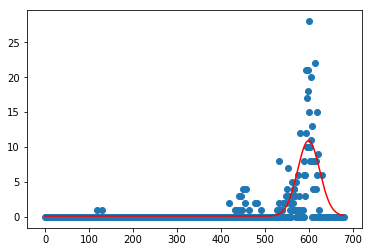

In [494]:
params = fit.extract(permuted=True)
plt.plot(np.mean(params['rate'], axis=0), c='r')
plt.scatter(np.arange(N), trajectories[0].astype(int))

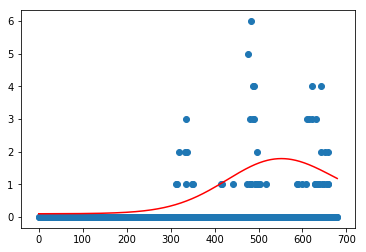

In [495]:
data = {
    'y': trajectories[1].astype(int),
    'N': N,
}
fit = model.sampling(data=data, chains=2, iter=2000)
params = fit.extract(permuted=True)
plt.plot(np.mean(params['rate'], axis=0), c='r')
plt.scatter(np.arange(N), trajectories[1].astype(int))

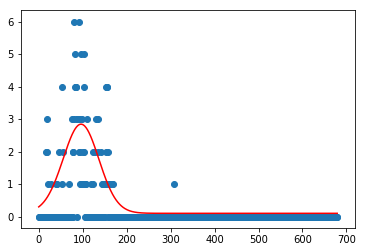

In [496]:
data = {
    'y': trajectories[3].astype(int),
    'N': N,
}
fit = model.sampling(data=data, chains=2, iter=2000)
params = fit.extract(permuted=True)
plt.plot(np.mean(params['rate'], axis=0), c='r')
plt.scatter(np.arange(N), trajectories[3].astype(int))

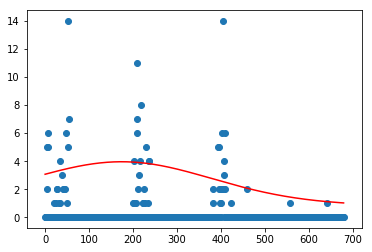

In [497]:
data = {
    'y': trajectories[4].astype(int),
    'N': N,
}
fit = model.sampling(data=data, chains=2, iter=2000)
params = fit.extract(permuted=True)
plt.plot(np.mean(params['rate'], axis=0), c='r')
plt.scatter(np.arange(N), trajectories[4].astype(int))

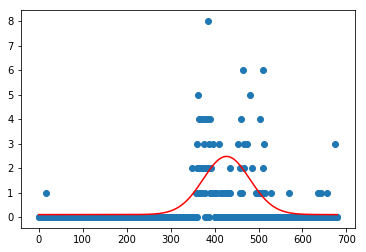

In [499]:
data = {
    'y': trajectories[5].astype(int),
    'N': N,
}
fit = model.sampling(data=data, chains=2, iter=2000)
params = fit.extract(permuted=True)
plt.plot(np.mean(params['rate'], axis=0), c='r')
plt.scatter(np.arange(N), trajectories[5].astype(int))

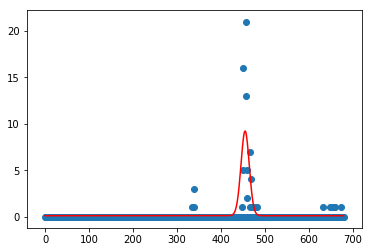

In [500]:
data = {
    'y': trajectories[6].astype(int),
    'N': N,
}
fit = model.sampling(data=data, chains=2, iter=2000)
params = fit.extract(permuted=True)
plt.plot(np.mean(params['rate'], axis=0), c='r')
plt.scatter(np.arange(N), trajectories[6].astype(int))

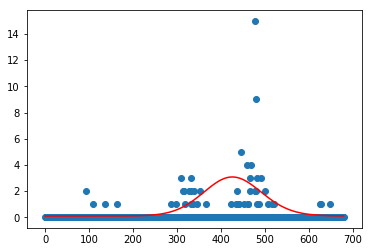

In [502]:
data = {
    'y': trajectories[7].astype(int),
    'N': N,
}
fit = model.sampling(data=data, chains=2, iter=2000)
params = fit.extract(permuted=True)
plt.plot(np.mean(params['rate'], axis=0), c='r')
plt.scatter(np.arange(N), trajectories[7].astype(int))

[]

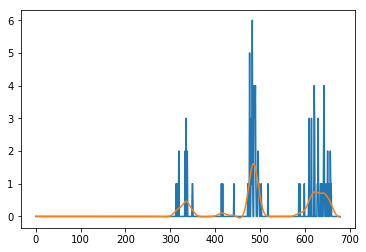

In [458]:
from scipy import signal
b, a = signal.butter(2, .05, 'lowpass') #first parameter is signal order and the second one refers to frequenc limit. I set limit 30 so that I can see only below 30 frequency signal component

plt.plot(trajectories[1])

output = signal.filtfilt(b, a,  trajectories[1])
plt.plot(output)

plt.plot()

[]

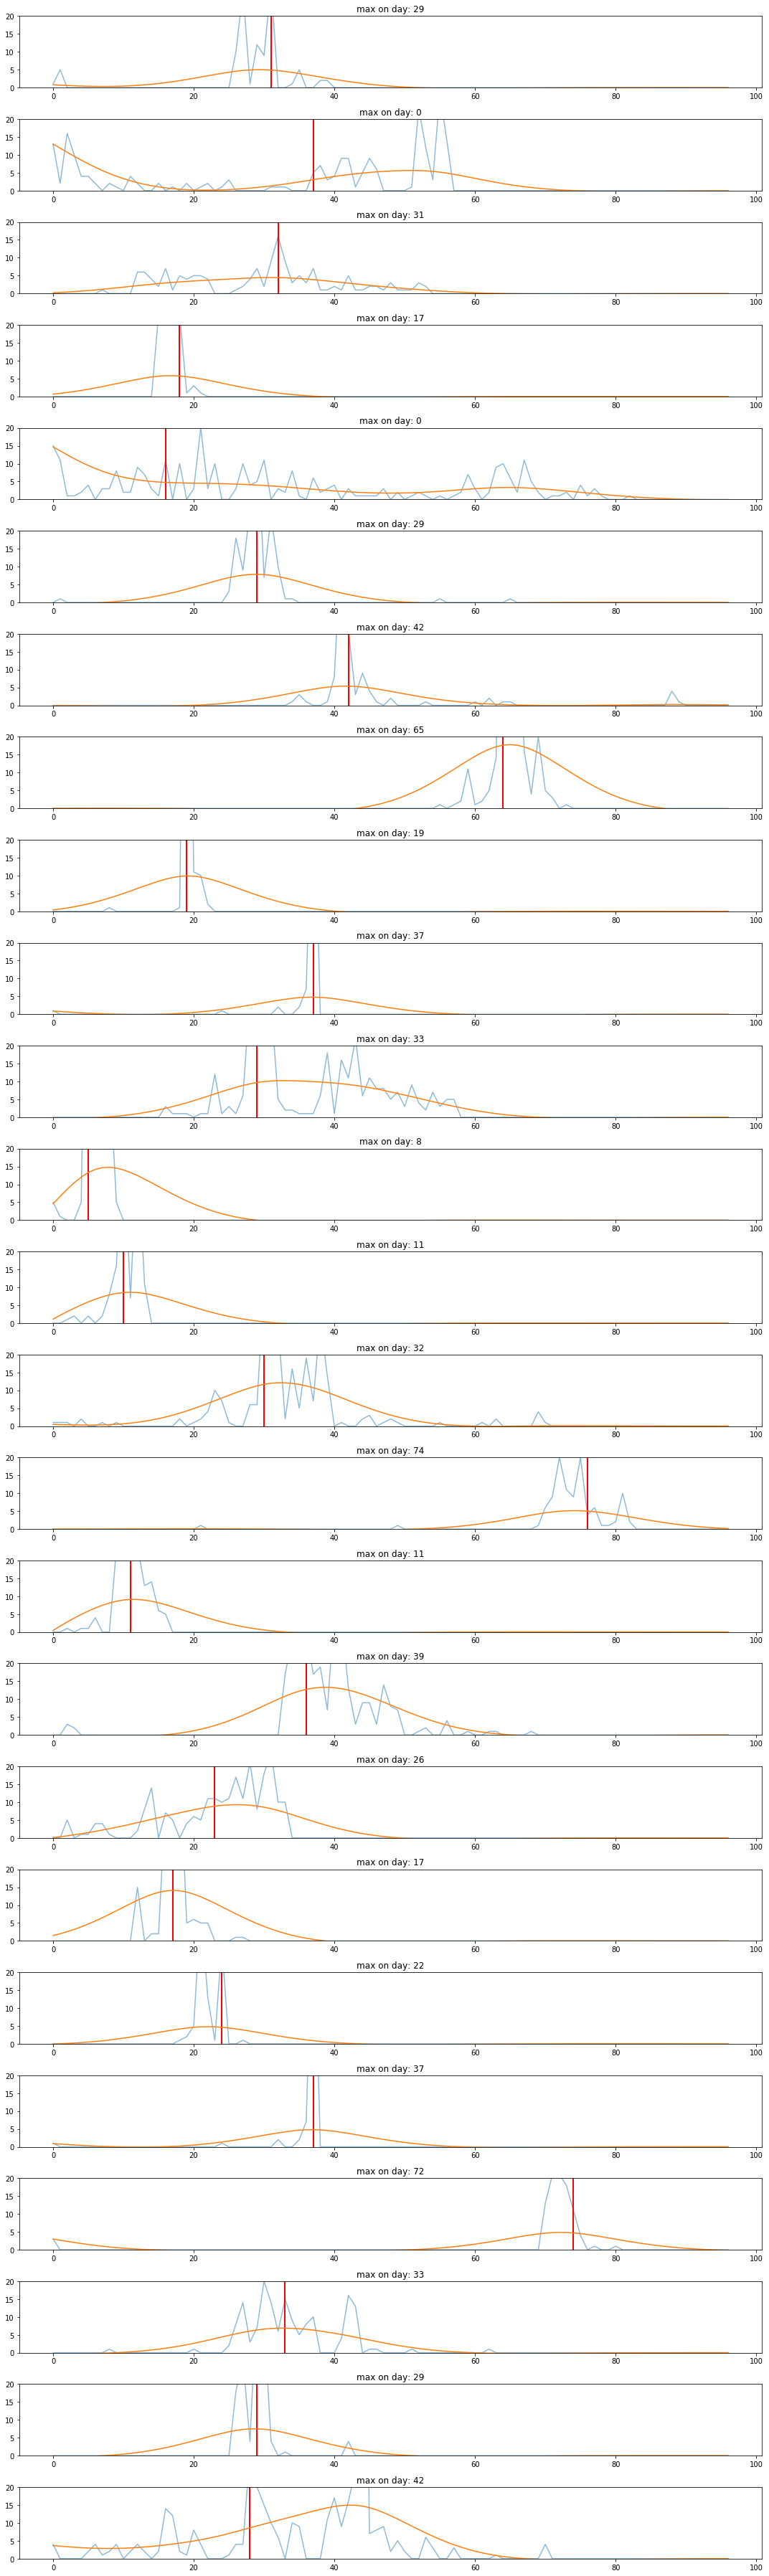

In [362]:
from scipy import signal
b, a = signal.butter(2, .05, 'lowpass') #first parameter is signal order and the second one refers to frequenc limit. I set limit 30 so that I can see only below 30 frequency signal component

fig, axes = plt.subplots(25,1,figsize=(15,50))

for ax in axes:
    index = np.random.choice(np.arange(len(trajectories)))
    ax.plot(trajectories[index], alpha=0.5)
    
    cumsum_traj = np.cumsum(trajectories[index])
    cumsum_traj = cumsum_traj >= 80
    day_of_80 = np.argmax(cumsum_traj)
    ax.axvline(day_of_80, lw=2, c='r')

    output = signal.filtfilt(b, a,  trajectories[index])
    ax.plot(output)
    ax.set_title(f'max on day: {np.argmax(output)}')
    ax.set_ylim([0,20])

fig.tight_layout()
plt.plot()

In [274]:
smoothed = np.zeros_like(trajectories)
b, a = signal.butter(2, .05, 'lowpass') #first parameter is signal order and the second one refers to frequenc limit. I set limit 30 so that I can see only below 30 frequency signal component

day_of_70_arr = []
day_of_80_arr = []
day_of_90_arr = []
day_of_best_rate_arr = []

for i, traj in enumerate(trajectories):
    output = signal.filtfilt(b, a, traj)
    cumsum_traj = np.cumsum(traj)
    cumsum_traj = cumsum_traj >= 70
    day_of_70_arr.append(np.argmax(cumsum_traj))
    
    cumsum_traj = np.cumsum(traj)
    cumsum_traj = cumsum_traj >= 80
    day_of_80_arr.append(np.argmax(cumsum_traj))
    
    cumsum_traj = np.cumsum(traj)
    cumsum_traj = cumsum_traj >= 90
    day_of_90_arr.append(np.argmax(cumsum_traj))
    
    day_of_best_rate_arr.append(np.argmax(output))

day_of_70_arr = np.array(day_of_70_arr)
day_of_80_arr = np.array(day_of_80_arr)
day_of_90_arr = np.array(day_of_90_arr)
day_of_best_rate_arr = np.array(day_of_best_rate_arr)

Text(0.5,1,'Count with best rate < 80: 204; Count with best rate > 80: 252')

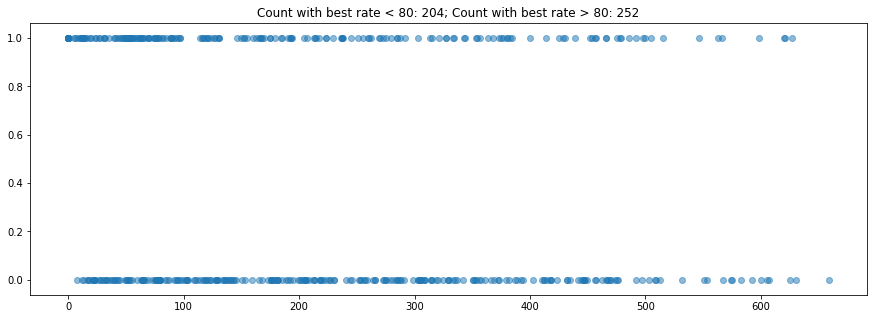

In [275]:
fig = plt.figure(figsize=(15,5))
count_with_best_rate_below_80 = np.array(day_of_best_rate_arr) < np.array(day_of_80_arr)
plt.scatter(day_of_best_rate_arr, count_with_best_rate_below_80, alpha=.5)
plt.title(f'Count with best rate < 80: {np.sum(count_with_best_rate_below_80)}; Count with best rate > 80: {np.sum(count_with_best_rate_below_80 == 0)}')

(array([ 3.,  3.,  4.,  2.,  3.,  1.,  3.,  3.,  1.,  2.,  7.,  3.,  4.,
        10., 11., 11., 14., 18., 27., 27., 31., 25., 15.,  9.,  8.,  9.,
         6.,  7.,  6.,  4.,  5.,  3.,  3.,  2.,  0.,  4.,  3.,  1.,  3.]),
 array([-19.        , -18.02564103, -17.05128205, -16.07692308,
        -15.1025641 , -14.12820513, -13.15384615, -12.17948718,
        -11.20512821, -10.23076923,  -9.25641026,  -8.28205128,
         -7.30769231,  -6.33333333,  -5.35897436,  -4.38461538,
         -3.41025641,  -2.43589744,  -1.46153846,  -0.48717949,
          0.48717949,   1.46153846,   2.43589744,   3.41025641,
          4.38461538,   5.35897436,   6.33333333,   7.30769231,
          8.28205128,   9.25641026,  10.23076923,  11.20512821,
         12.17948718,  13.15384615,  14.12820513,  15.1025641 ,
         16.07692308,  17.05128205,  18.02564103,  19.        ]),
 <a list of 39 Patch objects>)

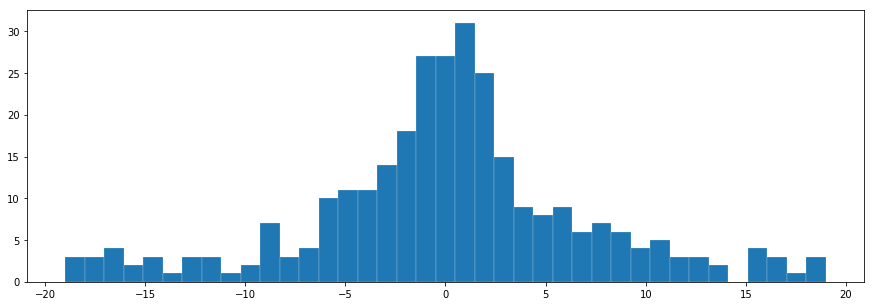

In [276]:
fig = plt.figure(figsize=(15,5))
diff = day_of_80_arr-day_of_best_rate_arr
diff = diff[(diff > -20) & (diff < 20)]
plt.hist(diff, bins=39, edgecolor='white', linewidth=.2)

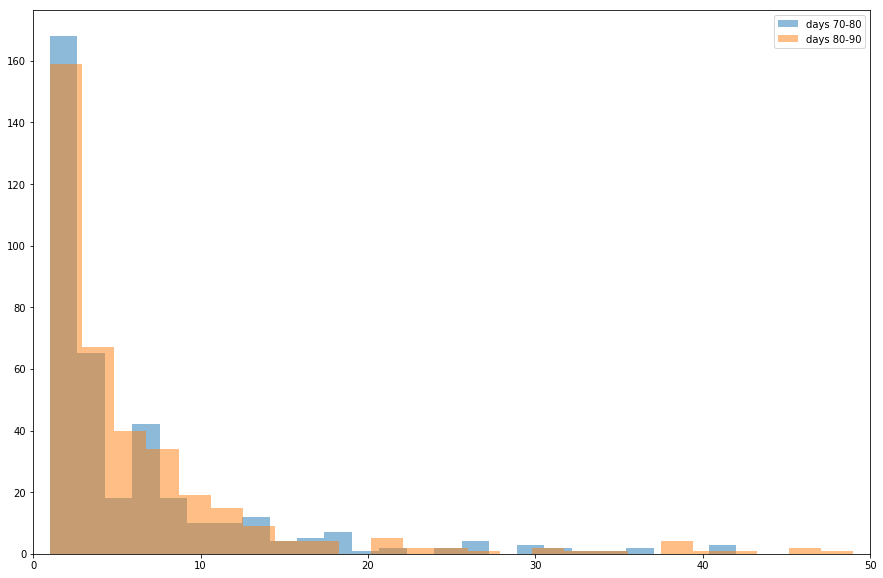

In [284]:
num_days_70_to_80 = day_of_80_arr - day_of_70_arr
num_days_80_to_90 = day_of_90_arr - day_of_80_arr

plt.figure(figsize=(15,10))
plt.xlim([0,50])

plt.hist(num_days_70_to_80[(num_days_70_to_80>0)&(num_days_70_to_80<50)], alpha=.5, bins=25, label='days 70-80')
plt.hist(num_days_80_to_90[(num_days_80_to_90>0)&(num_days_80_to_90<50)], alpha=.5, bins=25, label='days 80-90')
plt.legend(loc='best')

In [289]:
from sklearn.gaussian_process.kernels import RBF
from sklearn.gaussian_process import GaussianProcessRegressor

In [341]:
kernel = RBF(30)
# Instantiate a Gaussian Process model
gp = GaussianProcessRegressor(kernel=kernel, alpha=1, n_restarts_optimizer=10)
X = np.arange(0, N).reshape(-1,1)
y = trajectories[2]
gp.fit(X,y)

GaussianProcessRegressor(alpha=1, copy_X_train=True,
             kernel=RBF(length_scale=30), n_restarts_optimizer=10,
             normalize_y=False, optimizer='fmin_l_bfgs_b',
             random_state=None)

In [342]:
y_pred, sigma = gp.predict(X, return_std=True)

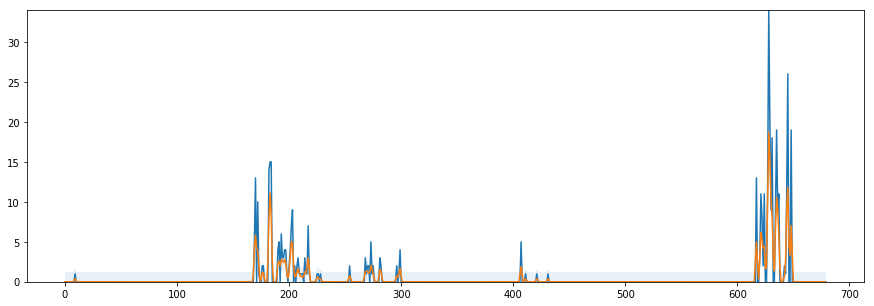

In [343]:
plt.figure(figsize=(15,5))

plt.fill_between(np.arange(N), y_pred+2*sigma, y_pred-2*sigma, alpha=.1)
plt.ylim([0,np.max(y)])
plt.plot(y)
plt.plot(y_pred)
plt.show()

In [299]:
sigma

array([0.62593756, 0.60115015, 0.57805193, 0.55699818, 0.53826517,
       0.52202986, 0.50835709, 0.49719713, 0.48839499, 0.48171044,
       0.47684534, 0.47347378, 0.47127022, 0.46993239, 0.4691971 ,
       0.46884874, 0.46872151, 0.46869667, 0.46869661, 0.46867715,
       0.46861925, 0.4685211 , 0.46839129, 0.46824318, 0.46809089,
       0.46794661, 0.46781919, 0.46771374, 0.4676319 , 0.46757254,
       0.46753266, 0.46750825, 0.46749508, 0.46748921, 0.4674874 ,
       0.46748723, 0.4674871 , 0.46748616, 0.46748411, 0.46748104,
       0.46747727, 0.4674732 , 0.46746919, 0.46746554, 0.46746246,
       0.46746001, 0.4674582 , 0.46745695, 0.46745618, 0.46745574,
       0.46745554, 0.46745547, 0.46745546, 0.46745546, 0.46745544,
       0.46745539, 0.46745531, 0.4674552 , 0.46745509, 0.46745498,
       0.46745487, 0.46745478, 0.46745471, 0.46745466, 0.46745462,
       0.46745459, 0.46745458, 0.46745457, 0.46745457, 0.46745457,
       0.46745457, 0.46745457, 0.46745457, 0.46745457, 0.46745

In [560]:
from scipy.special import factorial

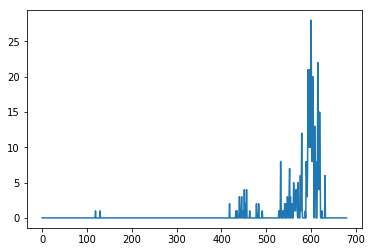

In [561]:
plt.plot(trajectories[0])

In [595]:
def likelihood_1(lambda_y, x):
    return -lambda_ + y*np.log(lambda_) - np.log(factorial(y))

In [596]:
def pois(k, lamb):
    return np.exp(-lamb)*lamb**k/(factorial(k))

In [597]:
np.log(pois(5,1))

-5.787491742782046

In [1751]:
import scipy.stats as stats
from scipy.special import logsumexp
from scipy.misc import derivative
from scipy.optimize import check_grad
from scipy.optimize import minimize

- stats.poisson(mu=1).logpmf(5)

5.787491742782046

In [1752]:
likelihood_1(y=5,x=0,lambda_=1)

5.787491742782046

In [2032]:
def get_lambda(Y, theta):
    alp, bet, sig, mu = theta 
    lambda_ = sigmoid(alp)+np.exp(bet - np.exp(sig)*np.square(x-sigmoid(mu)))
    return lambda_

def likelihood_1(lambda_, y, x):
    return lambda_ - y*np.log(lambda_)

def log_likelihood(theta, Y):
    
    x = np.arange(len(Y))/len(Y)
    alp, bet, sig, mu = theta
    lambda_ = get_lambda(Y, theta)
    logll = 0
    
    for y, xt, lam in zip(Y, x, lambda_):
        logll += likelihood_1(lam, y, xt)
        
    return logll

def grad_lambda_1(lambda_, y, x):
    return 1 - y/lambda_

def grad_alpha(grad_lambda, x, theta):
    alpha, bet, sig, mu = theta
    return np.exp(-alpha -2*(1+np.exp(-alpha)))

def grad_beta(grad_lambda, x, theta):
    alpha, bet, sig, mu = theta
    return np.exp(bet - np.exp(sig)*np.square(x-sigmoid(mu)))

def grad_sigma(grad_lambda, x, theta):
    alpha, bet, sig, mu = theta
    return np.exp(bet-np.exp(sig)*np.square(x-sigmoid(mu)))*(x-sigmoid(mu))**2*-np.exp(sig)

def grad_mu(grad_lambda, x, theta):
    alpha, bet, sig, mu = theta
    return np.exp(bet-np.exp(sig)*np.square(x-sigmoid(mu)))*-np.exp(sig)*2*(x-sigmoid(mu))*-1*np.exp(-mu-2*(1+np.exp(-mu)))

def sigmoid(x):
    return (1 + np.exp(-x))**-1

def grad_lambda(theta, Y):
    x = np.arange(len(Y))/len(Y)
    lambda_ = get_lambda(Y, theta)
    
    grad_alpha_ = 0
    grad_beta_ = 0 
    grad_sigma_ = 0
    grad_mu_ = 0
    
    for y, xt, lamb in zip(Y,x,lambda_):
        grad_l = grad_lambda_1(lamb, y, xt)
        grad_alpha_ += grad_l * grad_alpha(grad_l, xt, theta)
        grad_beta_ += grad_l * grad_beta(grad_l, xt, theta)
        grad_sigma_ += grad_l * grad_sigma(grad_l, xt, theta)
        grad_mu_ += grad_l * grad_mu(grad_l, xt, theta)
        
    return np.array([grad_alpha_, grad_beta_, grad_sigma_, grad_mu_])

In [2033]:
Y = trajectories[0]
theta = np.array([0, 0, 0, 0], dtype=np.float32)
log_likelihood(theta, Y)

819.3760546127738

In [2034]:
grad_lambda(theta, Y)

array([  6.27510491, 332.03741816,  -9.71475763,  -3.86947114])

In [2035]:
check_grad(log_likelihood, grad_lambda, theta, Y)

93.2552773103182

In [2038]:
# fmin = minimize(log_likelihood, theta, args=(Y,), jac=grad_lambda)
theta = np.array([0, 0, 0, 0], dtype=np.float32)
fmin = minimize(log_likelihood, theta, args=(Y,), options={'maxiter': 50})
fmin.x

array([-2.57143856,  2.14950021,  6.42787635,  1.95189207])

In [2011]:
theta = np.array([0, 0, 0, 0], dtype=np.float32)
for i in range(1,101):
    theta = theta - 1e-2*grad_lambda(theta, Y)
theta

array([ 0.37505036, -2.16844319,  0.10177961,  0.64832756])

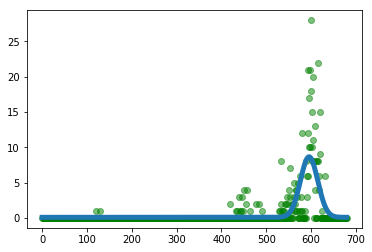

In [2039]:
x = np.arange(len(Y))/len(Y)

theta = fmin.x
alp, bet, sig, mu = theta
lambda_ = get_lambda(Y, theta)

plt.scatter(x*len(Y), Y, c='g', alpha=.5)
plt.plot(lambda_, lw=5)

In [1792]:
theta = np.array([0, 0, 0, np.argmax(Y)], dtype=np.float32)
for i in range(100):
    theta = theta - 1e-2*grad_lambda(theta, Y)

In [1793]:
# theta = np.array([1, 20, 1, 300], dtype=np.float32)
# fmin = minimize(log_likelihood, theta, args=(Y,))

In [1794]:
theta

array([ 1.69579267e-01,  1.80742827e-01, -4.12447027e+00,  5.99875026e+02])

In [1795]:
fmin

      fun: 606.2290823528477
 hess_inv: array([[ 0.56764713,  0.03193448,  0.19552239,  0.04597799],
       [ 0.03193448,  0.0103018 ,  0.02051456, -0.02339817],
       [ 0.19552239,  0.02051456,  0.0900097 , -0.01810115],
       [ 0.04597799, -0.02339817, -0.01810115,  0.46277067]])
      jac: array([-1.56819701e-17, -1.77203999e+00,  4.58900854e+01,  1.05280906e+01])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 114
      nit: 4
     njev: 102
   status: 2
  success: False
        x: array([ -3.15090183,   2.31831654,  -6.17540944, 604.48342771])

In [1736]:
sigmoid(alp)

1.0

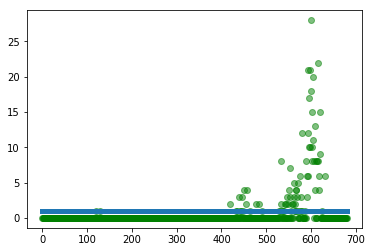

In [1940]:
thetas = []
for i, traj in enumerate(trajectories):
    theta = np.array([0, 0, 0, 0], dtype=np.float32)
    fmin = minimize(log_likelihood, theta, args=(traj,))
    thetas.append(fmin.x)
    print(i, fmin.x)

0 [-2.5714377   2.14950033  6.42787669  1.95189209]
1 [-58.10869316  -1.02426879   2.42000393   1.78186543]
2 [-1.72875184e+01  1.09037831e-02  4.88010457e-01  1.00372535e+02]
3 [-6.17323675  0.49803839  5.13563198 -1.77111715]
4 [-15.0039547   -0.52735995   1.10605772 -27.61270983]
5 [-4.06189853  0.19349898  4.43193728  0.47249641]
6 [-3.9068404   1.64174525  8.79524422  0.71925871]
7 [-3.86527707 -0.6607228   3.93436495  0.59379588]
8 [-3.04270275  0.72563791  6.48677804 -2.43491585]
9 [-1.75316450e+01  3.11574624e-01  2.16556328e+00  5.96938385e+02]
10 [-17.86729157   0.08171608   3.49049871  -1.59377301]
11 [-5.80573605 -0.47538419  2.70950038 -2.88741317]
12 [-4.7866518   1.84047596  8.23940272  0.872399  ]
13 [-20.57199269   0.15791321   3.46846396  23.2884929 ]
14 [-4.80956917  1.04462687  4.51731087 -1.25417513]
15 [-14.46344272   0.32790811   1.28740995 -22.78135403]
16 [ -3.54310709   1.65892137   3.96399535 -27.47682219]
17 [-4.88612807  3.87019303 10.50246975  1.69539638]


/home/nick/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


80 [-4.2724076   1.96995141  6.38657953 -1.30434361]
81 [-5.78429249  2.39665975  8.88361278 -0.21386517]
82 [-2.95011638  0.52675451  4.32158921  0.77127642]
83 [-3.41312568  1.64373614  8.53731435  0.01742898]
84 [-21.99242418   0.73386993   5.90626091   0.8343414 ]
85 [-3.69979188  2.10257059  8.61952875  0.57121808]
86 [-4.79501839  2.04264259  7.34296438  0.07193646]
87 [-3.18219679e+00  2.77532945e-02  2.71537053e+00 -5.50149412e+01]
88 [-19.08860647  -0.5983538    3.29252254   0.6365824 ]
89 [-5.23822842  0.41027054  5.37845489  1.1992638 ]
90 [-13.37354793   0.10459538   1.75947093  -0.51661346]
91 [-5.09205745  1.71252706  8.59562319 -0.31100465]
92 [-15.17517724  -0.2725797    1.63272989   0.05767954]
93 [-20.09913442  -0.5495474    2.65368473  44.27368222]
94 [-1.91496493  2.3015195   7.39997277 -0.70274761]
95 [-22.84340225   1.08316957   7.40058106  -0.09773817]
96 [-5.62393197  0.5986125   6.14496425  1.21589235]
97 [-15.23268085  -0.3427061    1.03952899  -2.5681198 ]
98

/home/nick/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


104 [-3.96199513  0.15340506  3.99921947  1.10877591]
105 [-13.1465746   -0.62415707  -0.36269107 -22.99332112]
106 [-3.53552018  0.24372453  4.71266696  0.6427755 ]
107 [-1.74351166e+01 -6.06884503e-01  3.66714669e+00  6.78217514e-03]
108 [-12.95823601  -0.10854234   1.96056679   0.10915123]
109 [-2.1218489   3.18299409  9.01049007  1.61166808]
110 [  -2.67391599    0.55429343    4.20325794 -391.46411371]
111 [-19.31811012  -0.10124347   0.72804417 -79.11389942]
112 [-13.0325845   -0.59703795   0.50756662 -38.29412565]
113 [-19.45178998  -0.32356191   4.33140736   0.63466491]
114 [-2.44024377  0.78615983  4.7710315   0.92510211]
115 [-16.98416076   0.25740318   1.92020833  -2.56501493]
116 [-3.65048243  1.55831857  6.2404988  -0.59026715]
117 [ -4.66682645   1.15621513   2.72592648 -16.15232041]
118 [-23.20118332   1.39430685   7.65065103   0.51728294]
119 [ -7.70219036  -0.80495565   1.47507735 -13.19441134]
120 [-3.88754503  0.09444634  4.76415223 -0.48111503]
121 [-16.276728    -0.

/home/nick/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


216 [-16.50655252   0.40633862   2.93825673  -0.72984081]
217 [-14.8116635   -0.89595343   1.54933015  -0.47716572]
218 [-18.86833592   0.38709861   1.79657635  -1.78654398]
219 [-18.52312575  -0.25281277   3.05367397  -0.72036061]
220 [-16.27227846  -0.49020267   2.01964787  -1.11997451]
221 [-2.72228536  2.00508677  8.13738174 -0.95904841]
222 [-17.27880258   0.89852056   4.1587913   -0.10547738]
223 [ -5.59694756   0.2417224    3.90612224 -18.12806426]
224 [-17.62146313   0.29142579   3.40051705  -0.53179903]
225 [-26.13183754  -0.11114944   3.546495   -41.92853312]
226 [-2.07620022e+01 -1.64842274e-02  3.84917436e+00 -3.76802899e+01]
227 [-4.75684808  1.30161965  6.87759034  0.51832588]
228 [-15.59393354  -0.35665976   4.00315734  -0.44191789]
229 [-5.60692963  1.36814542  5.74687773  0.06823813]
230 [-5.3704742   2.11558413  9.07720759  0.21217975]
231 [-18.11824697  -0.23338916   2.60687435 -19.0698341 ]
232 [-5.41546464  0.43521747  4.94699562 -0.60442347]
233 [-15.75167831   0.

/home/nick/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


304 [ -6.26738409   0.82196984   4.94672395 -21.33579207]


/home/nick/anaconda3/lib/python3.6/site-packages/scipy/optimize/optimize.py:1013: RuntimeWarning: divide by zero encountered in double_scalars
  rhok = 1.0 / (numpy.dot(yk, sk))


305 [-22.50857862   0.73622688   4.52535289 -28.01957586]
306 [-18.36530824  -0.48079143   2.44570303 -25.29048052]
307 [-21.05277025   0.41495044   4.03693092 -27.42651046]
308 [-17.81767763  -0.2202065    2.54673115  -0.69974124]
309 [-2.03829869  1.1528109   4.43973126 -0.44856688]
310 [-4.13987076  0.14999955  4.65859945 -0.25263346]
311 [-2.61270311  0.36143644  5.0494878  -0.22647675]
312 [-4.01179338  0.80501227  6.75731491 -0.82947283]
313 [-16.30401337   1.15976273   5.37175214  -0.73098983]
314 [-21.39055514   0.5093734    6.09988913  -0.26897855]
315 [ -5.38970541   0.87902781   5.3763739  -15.96811974]
316 [-4.23097894  1.92607514  7.66343882 -0.16989678]
317 [-14.92872091  -0.2153412    4.33900237  -0.83528297]
318 [-5.29712879  1.43949083  6.96032394 -2.28185657]
319 [-20.09940864   0.46451548   3.0461864   -3.30024726]
320 [ -6.34026277   0.73656162   4.62298727 -21.18480912]
321 [-18.53260157   0.09583031   4.19287108  -0.75289019]
322 [-16.90296639   1.38489096   5.806

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


330 [-2.41512950e+08  3.21341028e+03  1.77484843e+04  1.40446999e+08]
331 [ -2.73311169   1.22108086   4.61058258 -20.09969704]
332 [-3.41351457  0.67768586  5.65637083 -0.42808101]
333 [-4.89935126  1.25988913  6.13245605 -1.64473836]
334 [-1.63471556e+01  5.79822647e-03  1.45029449e+00 -5.73665524e+01]
335 [-18.82032515  -0.1255892    3.37013177 -29.29318517]
336 [-17.50465513   0.24456471   3.92863126  -1.34117385]
337 [-5.02950353  1.55595451  7.45240894 -0.85873903]
338 [ -6.26398252   1.81213245   4.8552626  -24.46168048]
339 [-15.86381314   0.32141035   4.44354253  -1.19048206]
340 [-20.74408558   0.78846867   4.81292484  -0.56015273]
341 [-5.78753233  0.78261612  4.73670349 -2.06980085]
342 [-133.00830956    0.59409178    5.25898785   -1.81120585]
343 [ -18.26103846    0.61996312    2.75823258 -137.4960136 ]
344 [-23.11253696   0.31078474   3.98710671  -0.50071609]
345 [-20.54768677   0.96973162   4.56072772  -0.59055883]
346 [-18.38244972   0.27264581   3.50296092  -2.06168887

/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in log
/home/nick/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:7: RuntimeWarning: invalid value encountered in double_scalars


438 [-3.17748521e+08  1.29213131e+04  1.62323599e+04  4.21347833e+07]
439 [-19.24792729   0.71708718   4.00108534 -17.21248232]
440 [-21.93703698   1.43764227   6.39875971  -1.86102609]
441 [-18.83416802   1.32765109   4.71558799 -21.80085541]
442 [-20.65024645   0.18293158   3.45818896 -21.89758463]
443 [-19.37640812   1.82090009   5.63844715  -2.39488497]
444 [-17.8066659    0.79140792   5.0420169  -28.59658062]
445 [-13.86411975   2.01507155   7.04316987  -2.64911773]
446 [-16.8437018    2.10234582   6.3570544   -3.0843707 ]
447 [-20.29193033   1.29032131   5.52194582  -2.54658405]
448 [-45.24997882   1.86288221   6.48042959  -3.03501997]
449 [-6.4313184   1.38964301  7.17539047 -4.63413145]
450 [-21.56542339   0.99470118   4.98669495 -29.30245338]
451 [-20.50261914   1.21360665   5.84132692 -31.59064043]
452 [-59.16449699   2.78868887   8.44037228  -2.80202082]
453 [-32.69442349   1.85916013   6.89379953  -3.30451307]
454 [-19.82960472   1.68252246   5.45156688 -28.62448715]
455 [-

In [2066]:
statistics = []

for i, Y in enumerate(trajectories):
    cumsum_traj = np.cumsum(Y)
    cumsum_traj = cumsum_traj > 80
    day_of_80 = np.argmax(cumsum_traj)
    
    theta = thetas[i]
    statistics.append([day_of_80, sigmoid(theta[3])*len(Y)])

[]

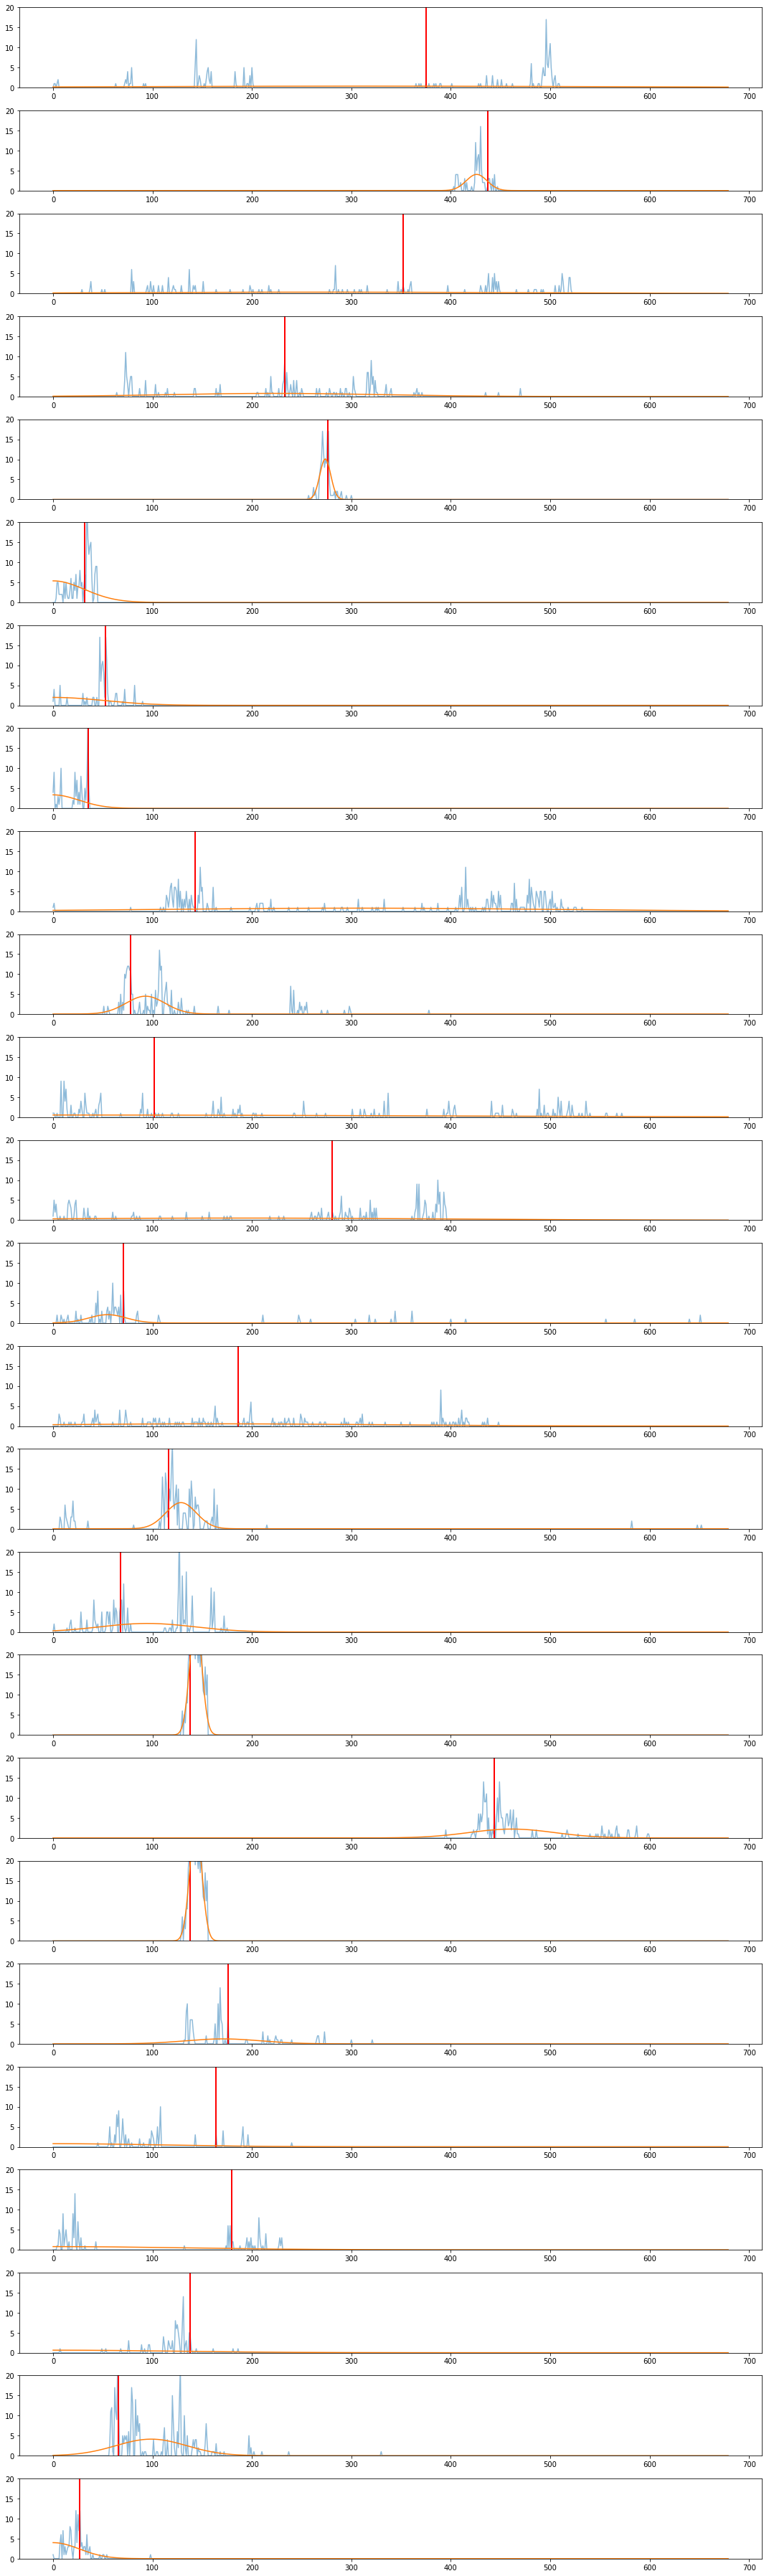

In [2063]:
fig, axes = plt.subplots(25,1,figsize=(15,50))

for i,ax in enumerate(axes):
    index = np.random.choice(np.arange(len(trajectories)))
    Y = trajectories[index]
    ax.plot(Y, alpha=0.5)
    
    cumsum_traj = np.cumsum(Y)
    cumsum_traj = cumsum_traj > 90
    day_of_80 = np.argmax(cumsum_traj)
    ax.axvline(day_of_80, lw=2, c='r')
    
    theta = thetas[index]
    lambda_ = get_lambda(Y, theta)

    ax.plot(lambda_)
    ax.set_ylim([0,20])
    
fig.tight_layout()
plt.plot()

(array([129.,  55.,  58.,  65.,  42.,  36.,  36.,  14.,   8.,  13.]),
 array([6.63444297e-168, 6.80000000e+001, 1.36000000e+002, 2.04000000e+002,
        2.72000000e+002, 3.40000000e+002, 4.08000000e+002, 4.76000000e+002,
        5.44000000e+002, 6.12000000e+002, 6.80000000e+002]),
 <a list of 10 Patch objects>)

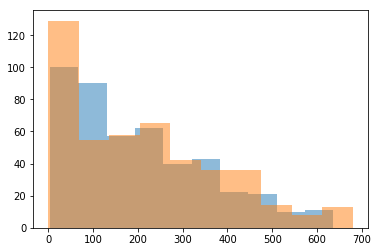

In [2069]:
statss = np.array(statistics)
# plt.scatter(statss[:,0], statss[:,1])
# plt.plot(np.arange(0,700), c='r')
# plt.xlabel('Day of 80')
# plt.ylabel('Day of biggest rate')
plt.hist(statss[:,0], alpha=.5)
plt.hist(statss[:,1], alpha=.5)

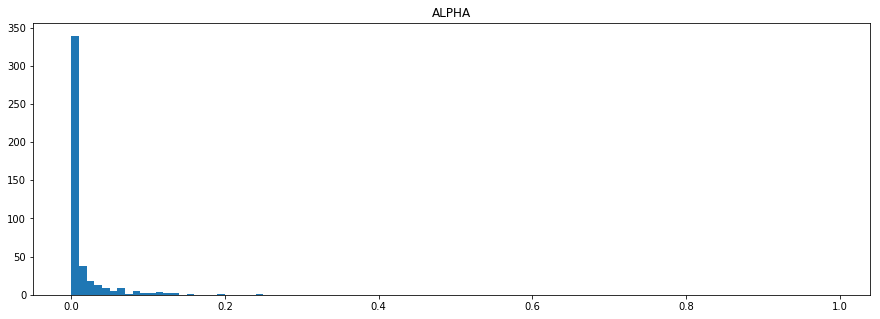

In [2113]:
thetas = np.array(thetas)
plt.figure(figsize=(15,5))
plt.title('ALPHA')
plt.hist(sigmoid(thetas[:,0]), bins=np.arange(0,1,.01))
plt.show()

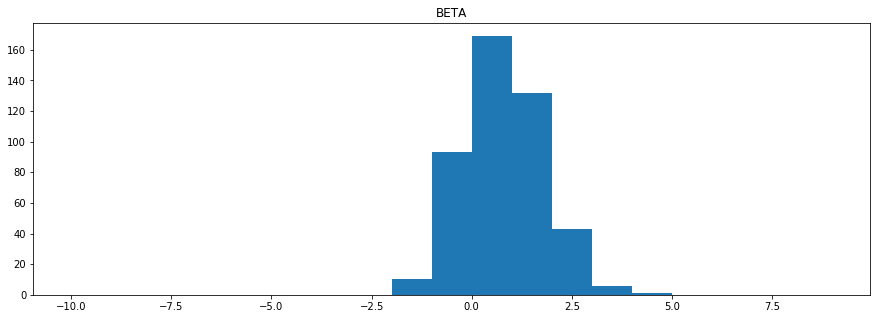

In [2083]:
plt.figure(figsize=(15,5))
plt.title('BETA')
plt.hist(thetas[:,1], bins=np.arange(-10,10,1))
plt.show()

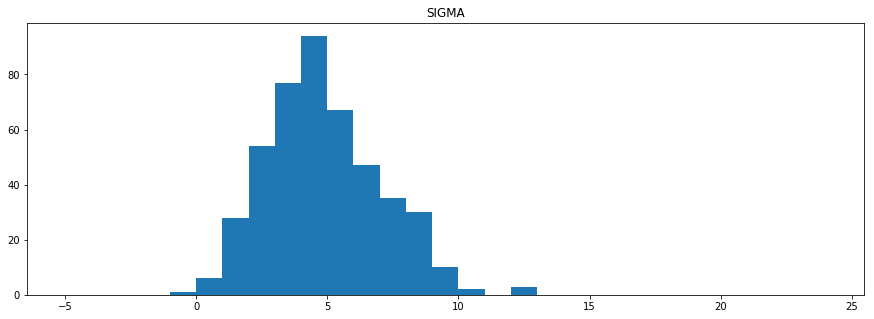

In [2086]:
plt.figure(figsize=(15,5))
plt.title('SIGMA')
plt.hist(thetas[:,2], bins=np.arange(-5,25,1))
plt.show()

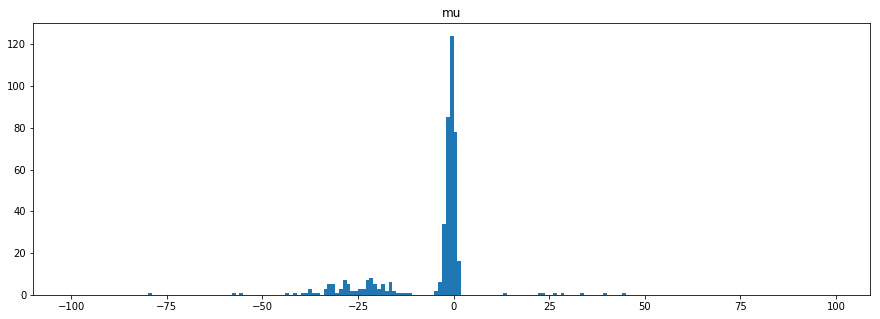

In [2088]:
plt.figure(figsize=(15,5))
plt.title('mu')
plt.hist(thetas[:,3], bins=np.arange(-100,100,1))
plt.show()

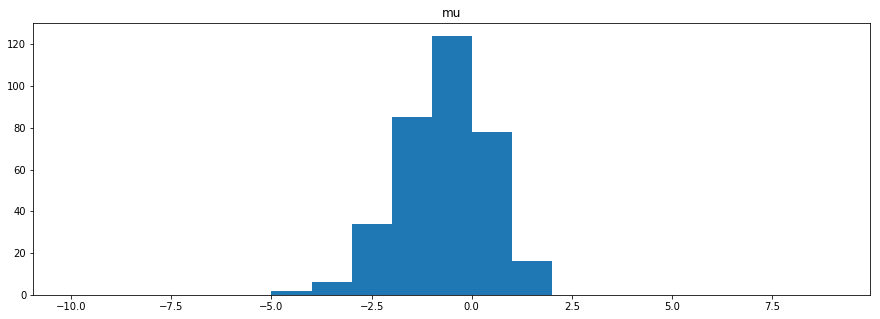

In [2089]:
plt.figure(figsize=(15,5))
plt.title('mu')
plt.hist(thetas[:,3], bins=np.arange(-10,10,1))
plt.show()

Text(0,0.5,'PEAK INTERACTION')

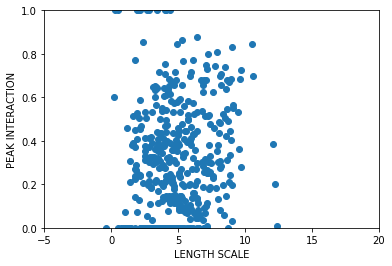

In [2110]:
plt.scatter(thetas[:,2], sigmoid(thetas[:,3]))
plt.xlim([-5,20])
plt.ylim([0,1])
plt.xlabel('LENGTH SCALE')
plt.ylabel('PEAK INTERACTION')

In [ ]:
plt.scatter(thetas[:,2], )
plt.xlim([-5,20])
plt.ylim([0,1])
plt.xlabel('LENGTH SCALE')
plt.ylabel('PEAK INTERACTION')

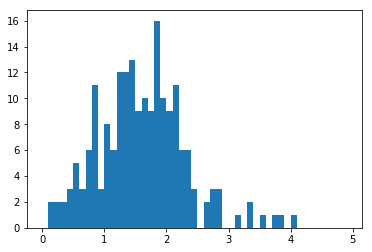

In [2126]:
plt.hist(thetas[thetas[:,2] > 5][:,1], bins=np.arange(0,5,.1))
plt.show()

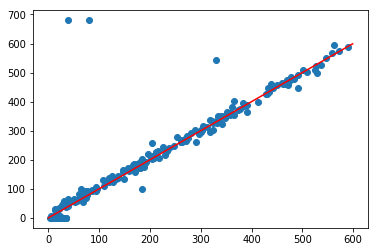

In [2152]:
s = statss[thetas[:,2] > 5]
plt.scatter(s[:,0],s[:,1])
plt.plot(np.arange(600), c='r')

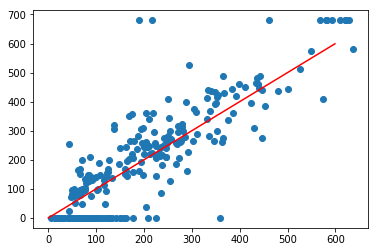

In [2153]:
s = statss[thetas[:,2] < 5]
plt.scatter(s[:,0],s[:,1])
plt.plot(np.arange(600), c='r')

81
271.5220588235294


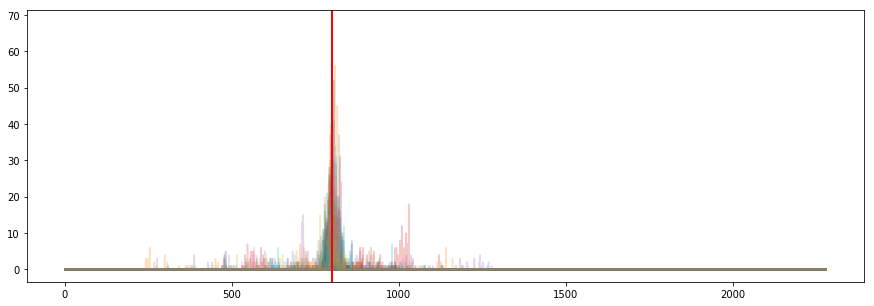

In [2167]:
plt.figure(figsize=(15,5))
for i, Y in enumerate(trajectories[thetas[:,2] > 7]):
    
    cumsum_traj = np.cumsum(Y)
    cumsum_traj = cumsum_traj > 80
    day_of_80 = np.argmax(cumsum_traj)
    Y = np.concatenate([np.zeros(800), Y, np.zeros(800)], axis=0)
    Y = np.roll(Y, -day_of_80)
    plt.plot(Y, alpha=.25)

print(i)
print(np.mean(np.cumsum(trajectories[thetas[:,2] > 7], axis=1)[-1]))

plt.axvline(800, c='r', lw=2)

88
215.5514705882353


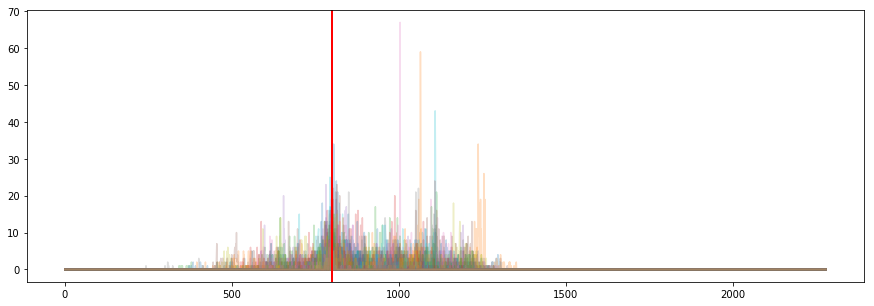

In [2181]:
plt.figure(figsize=(15,5))
for i, Y in enumerate(trajectories[thetas[:,2] < 3]):
    
    cumsum_traj = np.cumsum(Y)
    cumsum_traj = cumsum_traj > 80
    day_of_80 = np.argmax(cumsum_traj)
    Y = np.concatenate([np.zeros(800), Y, np.zeros(800)], axis=0)
    Y = np.roll(Y, -day_of_80)
    plt.plot(Y, alpha=.25)
    
print(i)
print(np.mean(np.cumsum(trajectories[thetas[:,2] < 2], axis=1)[-1]))

plt.axvline(800, c='r', lw=2)

284
165.18529411764706


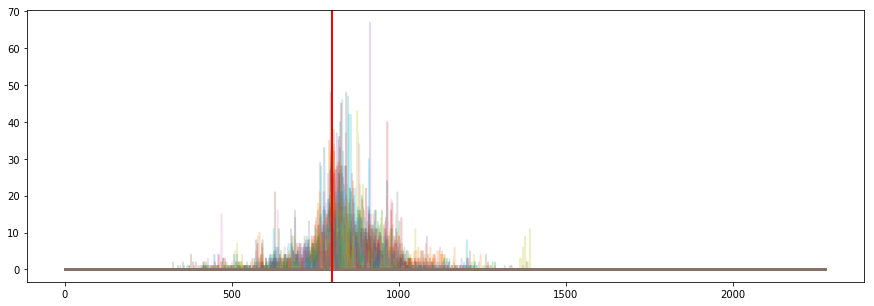

In [2182]:
plt.figure(figsize=(15,5))
for i, Y in enumerate(trajectories[(thetas[:,2] >= 3) & (thetas[:,2] < 7)]):
    
    cumsum_traj = np.cumsum(Y)
    cumsum_traj = cumsum_traj > 80
    day_of_80 = np.argmax(cumsum_traj)
    Y = np.concatenate([np.zeros(800), Y, np.zeros(800)], axis=0)
    Y = np.roll(Y, -day_of_80)
    plt.plot(Y, alpha=.25)
    
print(i)
print(np.mean(np.cumsum(trajectories[(thetas[:,2] >= 2) & (thetas[:,2] < 7)], axis=1)[-1]))

plt.axvline(800, c='r', lw=2)

In [2223]:
statsss = []
for i, (traj, thet) in enumerate(zip(trajectories, thetas)):
    num_inter = np.sum(traj)
    statsss.append([thet[1], thet[2]])
statsss = np.array(statsss)
statsss = statsss[statsss[:,1] < 50]

/home/nick/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/nick/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/nick/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/nick/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
/home/nick/anaconda3/lib/python3.6/site-pack

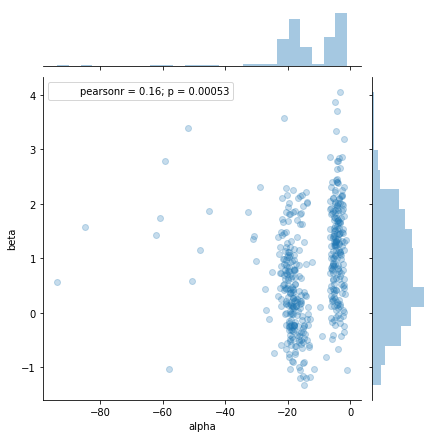

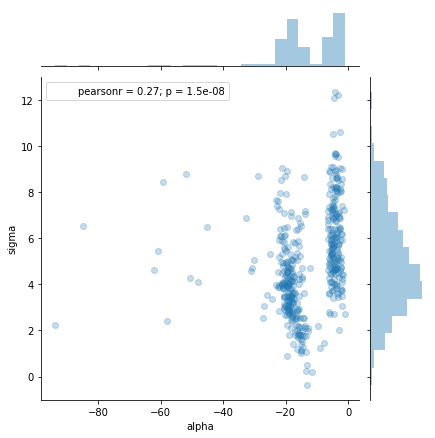

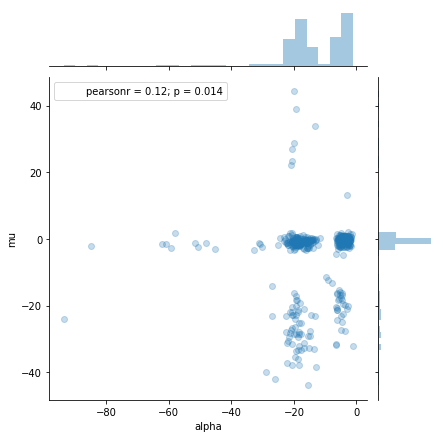

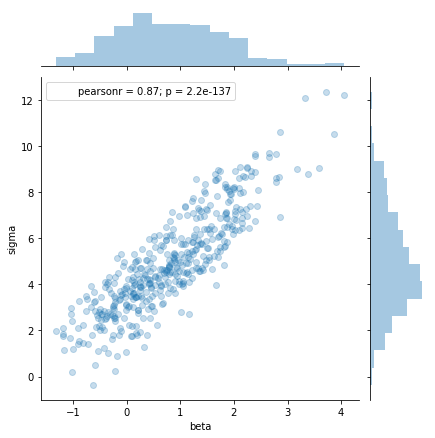

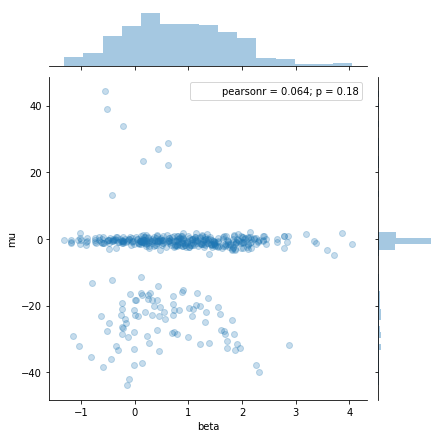

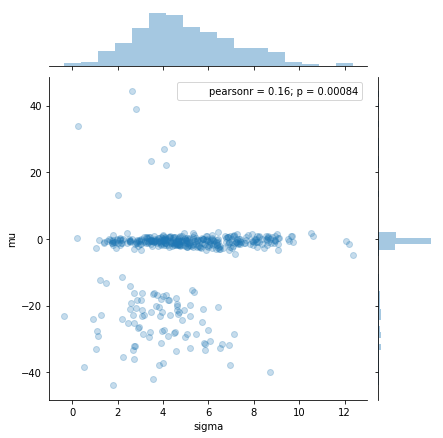

In [2230]:
thet = thetas[(thetas[:,2] < 50)&(thetas[:,0] > -100)&(np.abs(thetas[:,3]) < 50)]
# fig, ax = plt.subplots(1,1,figsize=(15,5))
sns.jointplot(thet[:,0], thet[:,1],  alpha=.25).set_axis_labels("alpha", "beta")

sns.jointplot(thet[:,0], thet[:,2],  alpha=.25).set_axis_labels("alpha", "sigma")

sns.jointplot(thet[:,0], thet[:,3],  alpha=.25).set_axis_labels("alpha", "mu")

sns.jointplot(thet[:,1], thet[:,2],  alpha=.25).set_axis_labels("beta", "sigma")

sns.jointplot(thet[:,1], thet[:,3],  alpha=.25).set_axis_labels("beta", "mu")

sns.jointplot(thet[:,2], thet[:,3],  alpha=.25).set_axis_labels("sigma", "mu")

# plt.axvline(80, c='r')
# plt.axvline(500, c='r')
# plt.axhline(3, c='r')
# plt.axhline(7, c='r')

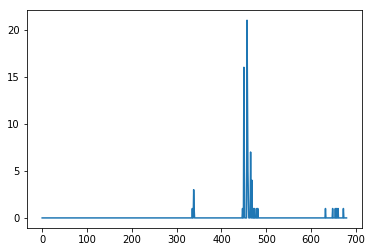

In [2222]:
plt.plot(trajectories[6])